In [1]:
# Set local python and nltk paths
import sys
sys.path.insert(0,'/vol/medic02/users/ag6516/miniconda/envs/PyTorch27/lib/python2.7/site-packages')
sys.path.insert(0,'/vol/medic02/users/ag6516/miniconda/envs/PyTorch27/lib/python2.7/site-packages/setuptools-27.2.0-py2.7.egg')
sys.path.insert(0,'/vol/medic02/users/ag6516/miniconda/envs/PyTorch27/lib/python2.7/site-packages/IPython/extensions')
sys.path
import nltk
nltk.data.path = ['/vol/medic02/users/ag6516/nltk_data']

In [37]:
import csv
import pandas as pd
import numpy as np
from read_data import read_csv_into_df
from vis_utils import kmeans_clustering, plot_pca, visualise_word_clusters2, kmeans_silhouette
from vis_utils import save_clusters_to_json, load_clusters_from_json

In [3]:
fields = ['Accession', 'Clinical history', 'Comment', 'Report text']
dir = ('/vol/medic02/users/ag6516/x_ray_fracture_localisation/')#
# dir = ('/Users/Aydan/PhD/x_ray_fracture_localisation/')

with open(dir + 'data/Reports/XKNEB_Jan_Dec_2015_anon.csv', 'rU') as csvfile:
    data1 = csv.reader(csvfile, delimiter=',')
    headers1 = data1.next()

with open(dir + 'data/Reports/XKNEB_Jan_Dec_2016_anon.csv', 'rU') as csvfile:
    data2 = csv.reader(csvfile, delimiter=',')
    headers2 = data2.next()

# with open(dir + 'data/Reports/XKNEB_Jan_Jul_2017_anon.csv', 'rU') as csvfile:
#     data3 = csv.reader(csvfile, delimiter=',')
#     headers3 = data3.next()

cols1 = [headers1.index(item) for item in fields]
cols2 = [headers2.index(item) for item in fields]
# cols3 = [headers3.index(item) for item in fields]

In [4]:
df1 = read_csv_into_df(dir + 'data/Reports/XKNEB_Jan_Dec_2015_anon.csv', fields, cols1)
df2 = read_csv_into_df(dir + 'data/Reports/XKNEB_Jan_Dec_2016_anon.csv', fields, cols2)

In [5]:
df = pd.concat([df1,df2])
print df.count()

Accession           3576
Clinical history    2232
Comment             2402
Report text         3576
dtype: int64


In [6]:
# Check for missing information
df_nans = df[df.isnull().any(axis=1)]
df_nans.to_csv('missing_info.csv', sep=',')

In [7]:
df.to_csv('cleaned_reports.csv', sep=',')

In [6]:
# Basic filtering and stats
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import numpy as np
import random
random.seed(123)
np.random.seed(123)

reports = []
reports_tok = []
labels = []
words = []
for i, row in df.iterrows():
    report = row['Report text'].decode('utf-8').lower()
    
    # Replace unnecessary punctuation 
    for char in ['~', '"']:
        report = report.replace(char, '')
        
    for char in ['!', '?', ';', ':', '.']:
        report = report.replace(char, ' . ')
    
    for char in ['(', ')', ',', '/']:
        report = report.replace(char, ' , ')
        
    # Tokenize
    report_tok = word_tokenize(report)
    
    # Remove stopwords
    filtered_report_tok = [word for word in report_tok if word not in stopwords.words('english')]
    filtered_report = ' '.join(filtered_report_tok)
    
    reports.append(filtered_report)
    reports_tok.append(filtered_report_tok)
    labels.append(row['Accession'])
    [words.append(word) for word in filtered_report_tok]

print 'Vocab length: ', len(sorted(set(words)))
print 'Avg no. of appearances: ', len(words)/len(sorted(set(words)))
fdist_all = nltk.FreqDist(words)
freqs = [freq for _, freq in fdist_all.most_common()]
print 'STD: ', np.std(freqs)
#print fdist_all.hapaxes()
print 'Number of reports: ', len(reports)

Vocab length:  1770
Avg no. of appearances:  51
STD:  387.271636453
Number of reports:  3576


Populating the interactive namespace from numpy and matplotlib
['.', 'knee', 'joint', 'xr', ',', 'medial', 'changes', 'degenerative', 'seen', 'space', 'right', 'patellofemoral', 'left', 'joints', 'change', 'compartment', 'previous', 'bilaterally', 'noted', 'loss', 'comparison', 'narrowing', 'spaces', 'compartments', 'tibiofemoral', 'mild', 'bilateral', 'osteophyte', 'imaging', 'bony', 'significant', 'moderate', 'osteophytosis', 'formation', 'within', 'lateral', 'made', 'knees', 'tibial', 'femoral', 'minor', 'osteoarthritic', 'marked', 'evidence', 'severe', 'preserved', 'acute', 'appearances', 'reduction', 'bone']


/vol/medic02/users/ag6516/miniconda/envs/PyTorch27/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['char', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


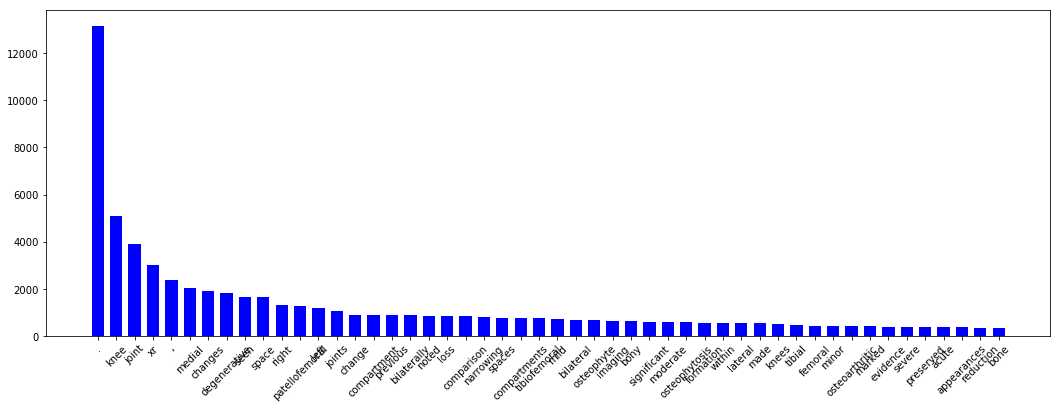

In [11]:
# Vocab stats
import matplotlib.pyplot as plt
#%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (18, 6)

hist = [(word,freq) for word, freq in fdist_all.most_common(50)]
#fdist_all.plot(50)

words = [str(word) for word in zip(*hist)[0]]
print words
counts = range(len(words))
frequency = zip(*hist)[1]

plt.bar(counts, frequency, 1/1.5, color="blue", align='center')
plt.xticks(counts, words, rotation=45)
fig = plt.gcf()

# 1. Doc2Vec
From the gensim library: doc2vec can be used to embed documents through a distributed memory and distributed bag of words approach (Mikolov 2014)

__[Quoc Le and Tomas Mikolov. Distributed Representations of Sentences and Documents](https://arxiv.org/pdf/1405.4053v2.pdf)__

In [7]:
# Generate Doc2Vec embeddings for reports
import gensim
from gensim.models.doc2vec import LabeledSentence

class DocIterator(object):
    def __init__(self, doc_list, labels_list):
        self.labels_list = labels_list
        self.doc_list = doc_list
    def __iter__(self):
        for idx, doc in enumerate(self.doc_list):
            yield LabeledSentence(words=doc, tags=[self.labels_list[idx]])
            
it = DocIterator(reports, labels)

## 1.1 Training doc2vec model
The model is trained on the entire text for 10 iterations

In [11]:
# Train model
model_d2v = gensim.models.Doc2Vec(size=300, min_count=0, alpha=0.025, min_alpha=0.025)
model_d2v.build_vocab(it)
#training of model
for epoch in range(10):
    print 'iteration ' +str(epoch+1)
    model_d2v.train(it, total_examples=model_d2v.corpus_count, epochs=model_d2v.iter)
    model_d2v.alpha -= 0.002
    model_d2v.min_alpha = model_d2v.alpha
    model_d2v.train(it, total_examples=model_d2v.corpus_count, epochs=model_d2v.iter)
#save the created model
model_d2v.save('doc2vec.model')

iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10


In [8]:
# Or load pre-trained model
model_d2v = gensim.models.Doc2Vec.load('doc2vec.model')

## 1.2 Sampling report embeddings
We can test the embeddings by taking a sample of most simlar documents to a randomly sampled report

In [12]:
# Test model
pd.options.display.max_colwidth = 4000
label_sample = random.choice(labels)
report_sample = df.loc[df['Accession'] == label_sample]['Report text']
print "Sample document: \n"
print report_sample.to_string()

most_similar = model_d2v.docvecs.most_similar(label_sample)
print "\nMost similar documents: \n"

for label, _ in most_similar:
    print (df.loc[df['Accession'] == label]['Report text']).to_string()
    print ''

Sample document: 

349    XR Knee Both : \n\nLeft knee: There is severe OA change to the patellofemoral joint with less severe OA in the medial compartment of the knee joint. Alignment maintained.\n\nRight knee: TKR in situ. No previous images available for comparison. Good alignment. No adverse features.

Most similar documents: 

508    XR Knee Both : \n\nLeft knee: Unicompartment replacement of the medial joint. Good alignment. No adverse features.\n\nRight knee: TKR. Good alignment. No adverse features.

2538    XR Knee Both : Both knees have severe patellofemoral joint arthritis. And there is OA change in the medial compartment of the left knee joint causing a slight varus deformity.

3028    Both knees: There is severe degenerative change in the medial compartment of the left knee joint causing a varus angulation. There is similar but less severe change in the right knee joint.

3250    Left knee: Left TKR. Good alignment. No adverse features.\n\nRight knee: There is mild OA chan

## 1.3 Kmeans of doc2vec
The report embeddings can be grouped together using kmeans with a cluster size of 4. This is based on the assumption that we have 4 main pathologies present in the reports:
1. Osteoarthritis
2. Knee replacement
3. Fractures
4. No present pathologies

In [13]:
# Cluster documents using K-means
num_clusters_d2v = 4

# generate d2v embeddings
embeddings_d2v = []
for label in labels:
    embeddings_d2v.append(model_d2v.docvecs[label])

kmeans_labels_d2v = kmeans_clustering(embeddings_d2v, num_clusters_d2v)

In [42]:
# Save clusters to json
filename = 'kmeans_doc2vec1.json'
save_clusters_to_json(labels, reports, kmeans_labels_d2v, num_clusters_d2v, filename)

In [43]:
# Load clusters from json
clusters_d2v = load_clusters_from_json('kmeans_doc2vec1.json')

## 1.4 Wordclouds of Clusters
Wordclouds can be used to get an idea of the dominant words in each cluster

### Evaluation
Clusters are not distinct, each cluster contains reference to degeneration (a sign of OA)
1. Cluster 1 has a high occurance of femoral, tibial, lateral. 
2. Cluster 2 has a high occurance of medial, loss, OA
3. Cluster 3 has a high occurance of patellofemoral, tibiafemoral
4. Cluster 4 is a mix of the above

Reports in cluster2 869

Reports in cluster3 787

Reports in cluster0 921

Reports in cluster1 999



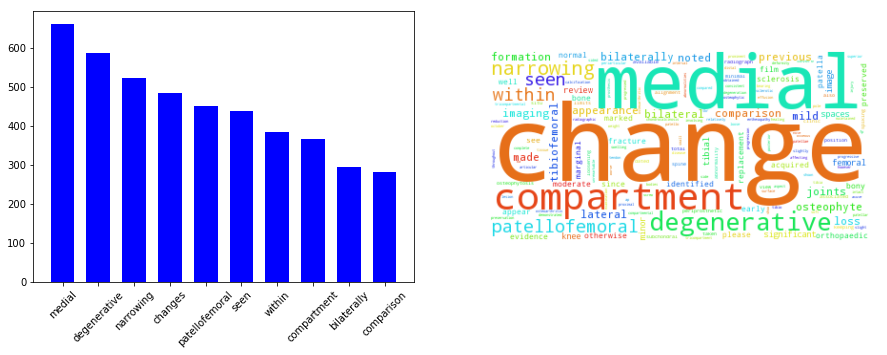

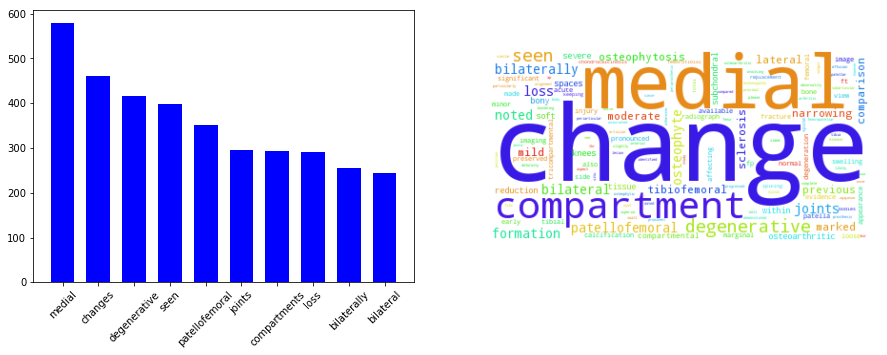

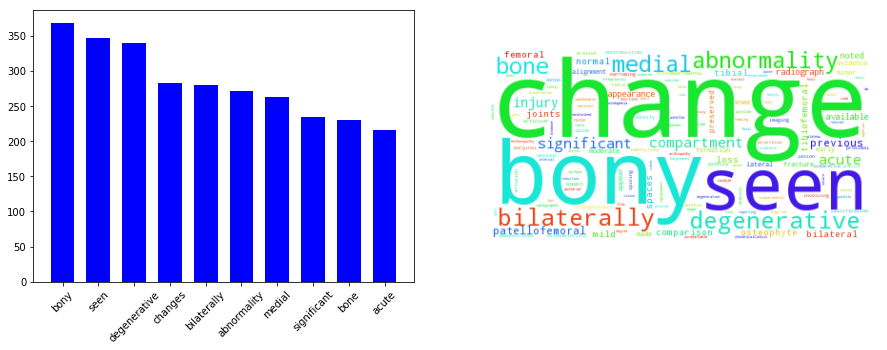

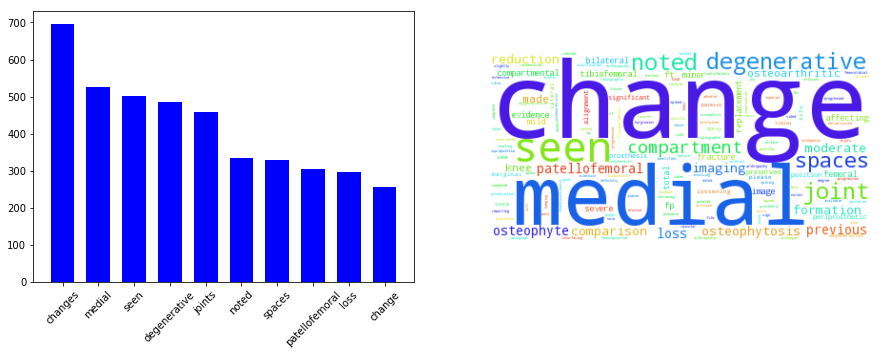

In [44]:
# Visualise words in clusters
%matplotlib inline
pd.options.display.max_colwidth = 4000

mystoplist = ['xr', 'knee', 'both', 'x-ray', 'joint', 'left', 'right', 'space', ':', '.', ',']
stoplist = mystoplist + stopwords.words('english')
visualise_word_clusters2(clusters_d2v, stoplist)

## 1.5 PCA of Clusters and Embeddings
The clustered report embeddings can be reduced using PCA to 2D and plotted. 

<IPython.core.display.Javascript object>


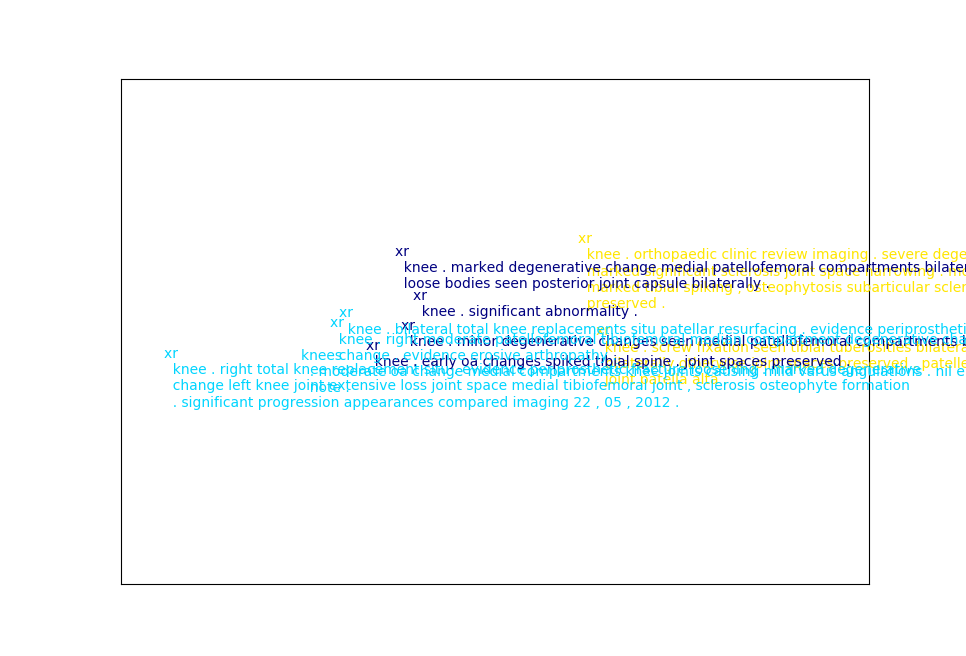

In [14]:
# Plot reports and clusters using PCA
# pylab.rcParams['figure.figsize'] = (18, 10)
pd.options.display.max_colwidth = 4000
%matplotlib notebook
%matplotlib notebook

# PCA
num_samples_pca = 10
reports_linebreaks = []
for report in reports:
    words = report.split()
    new_r = []
    for i, word in enumerate(words):
        new_r.append(word)
        if i%15==0:
            new_r.append(' \n ')
    reports_linebreaks.append(' '.join(new_r))

plot_pca(embeddings_d2v, reports_linebreaks, kmeans_labels_d2v, num_clusters_d2v, num_samples_pca)

# 2. InferSent
InferSent is a sentence embeddings method from Facebook, trained on natural language inference data.

__[Alexis Conneau et al. Supervised Learning of Universal Sentence Representations from Natural Language Inference Data](https://arxiv.org/abs/1705.02364)__

Encoder and trained models can be downloaded from here: __[InferSent](https://github.com/facebookresearch/InferSent)__

In [16]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from random import randint
import matplotlib
import torch
torch.set_num_threads(1)

GLOVE_PATH = dir + 'InferSent/GloVe/glove.840B.300d.txt'
print GLOVE_PATH

/vol/medic02/users/ag6516/x_ray_fracture_localisation/InferSent/GloVe/glove.840B.300d.txt


In [17]:
model_is = torch.load('infersent.allnli.pickle')
model_is.set_glove_path(GLOVE_PATH)

/vol/medic02/users/ag6516/miniconda/envs/PyTorch27/lib/python2.7/site-packages/torch/serialization.py:286: SourceChangeWarning: source code of class 'models.BLSTMEncoder' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/vol/medic02/users/ag6516/miniconda/envs/PyTorch27/lib/python2.7/site-packages/torch/serialization.py:286: SourceChangeWarning: source code of class 'torch.nn.modules.rnn.LSTM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


## 2.1 Create InferSent Embeddings
The InferSent model was trained using [GloVe](https://nlp.stanford.edu/projects/glove/) vectors, so words outside the glove vocab will not be encoded.

In [18]:
report_samples_is = reports[:10]

model_is.build_vocab(reports, tokenize=True)
embeddings_is = model_is.encode(reports, bsize=128, tokenize=True, verbose=True)
print('nb sentences encoded : {0}'.format(len(embeddings_is)))

Found 1601(/1772) words with glove vectors
Vocab size : 1601
Nb words kept : 97107/98907 (98.18 %)


models.py:53: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greately increasing memory usage. To compact weights again call flatten_parameters().
  sent_output = self.enc_lstm(sent_packed)[0]  # seqlen x batch x 2*nhid


Speed : 336.62 sentences/s (gpu mode, bsize=128)
nb sentences encoded : 3576


## 2.2 Measure cosine similarity between report embeddings

In [123]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

report_sample1 = random.choice(reports)
print "Sample report 1: ", report_sample1

report_sample2 = random.choice(reports)
print "Sample report 2: ", report_sample2

print cosine(model_is.encode([report_sample1])[0], model_is.encode([report_sample2])[0])

Sample report 1:  xr knee . left knee right knee symptomatic . images compared previous 2013 . previous surgery noted . slight loss cartilage space medial compartment patellofemoral joint . alignment maintained . joanne hargreaves locum reporting radiographer ra28194
Sample report 2:  normal appearances right knee . evidence fracture dislocation . evidence intra-articular loose fragment . within left knee , ap view demonstrates small avulsed fragment arising medial tibial spine . mri advised evaluation .
0.873459


## 2.3 Visualise word importance

Populating the interactive namespace from numpy and matplotlib
Sample document: 

xr knee . moderate osteoarthritic changes seen knees tp tf joints loss joints spaces , osteophytosis bones osteopenic .


/vol/medic02/users/ag6516/miniconda/envs/PyTorch27/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['hist']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


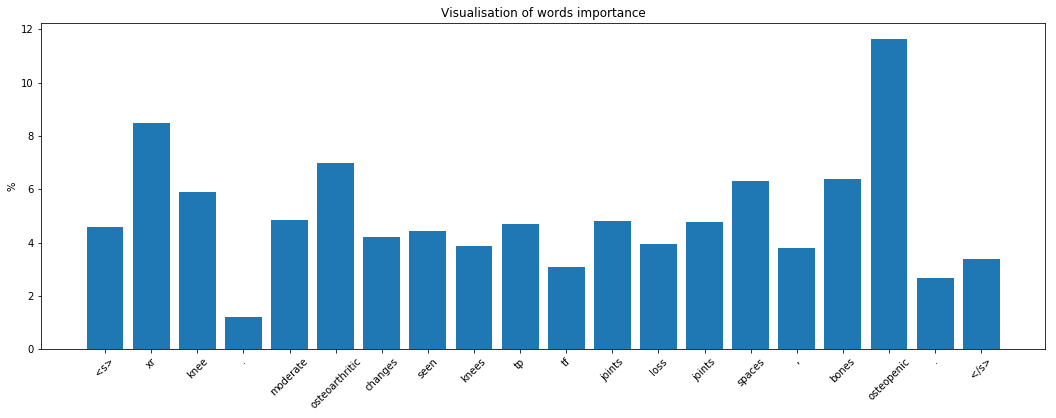

(Variable containing:
  4.0905e-02  2.9435e-02  2.8372e-01  ...   6.8168e-02 -1.1871e-02  6.2135e-03
 [torch.cuda.FloatTensor of size 1x4096 (GPU 0)],
 array([[ 7,  6, 13, ..., 16,  4,  2]]))

In [124]:
%pylab inline
pylab.rcParams['figure.figsize'] = (18, 6)

report_sample = random.choice(reports)
print "Sample document: \n"
print report_sample

model_is.visualize(report_sample, tokenize=True)

## 2.4 K-means silhouette evaluation
The silhouette score is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.

2  clusters
12  clusters
22  clusters
32  clusters
42  clusters


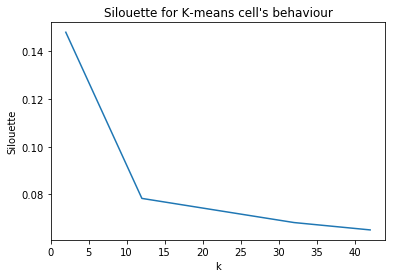

In [19]:
# Perform k-means on a range of k, evaluate silhouette
scores = kmeans_silhouette(embeddings_is, list(range(2,50,10)))

## 2.5 K-means of InferSent embeddings

In [19]:
# Cluster documents using K-means
num_clusters_is = 10

kmeans_labels_is = kmeans_clustering(embeddings_is, num_clusters_is)

In [27]:
# Save clusters into json
filename = 'kmeans_clusters_infersent3.json'
save_clusters_to_json(labels, reports, kmeans_labels_is, num_clusters_is, filename)

In [35]:
# Load clusters from json
clusters_is = load_clusters_from_json('kmeans_clusters_infersent3.json')

## 2.6 Wordclouds of Clusters

Reports in cluster8 112

Reports in cluster9 330

Reports in cluster2 325

Reports in cluster3 64

Reports in cluster0 649

Reports in cluster1 511

Reports in cluster6 283

Reports in cluster7 414

Reports in cluster4 580

Reports in cluster5 308



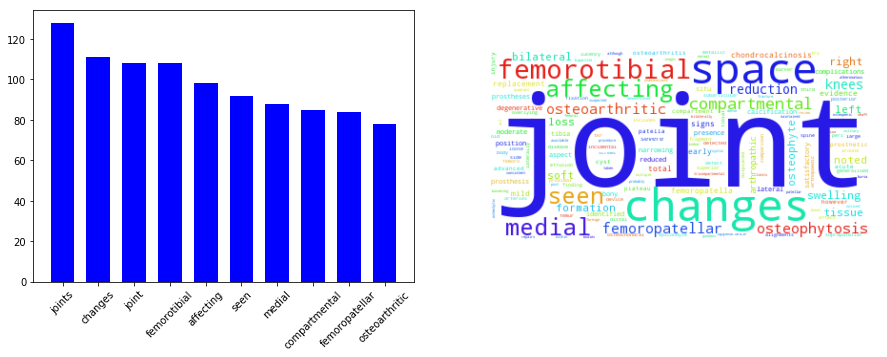

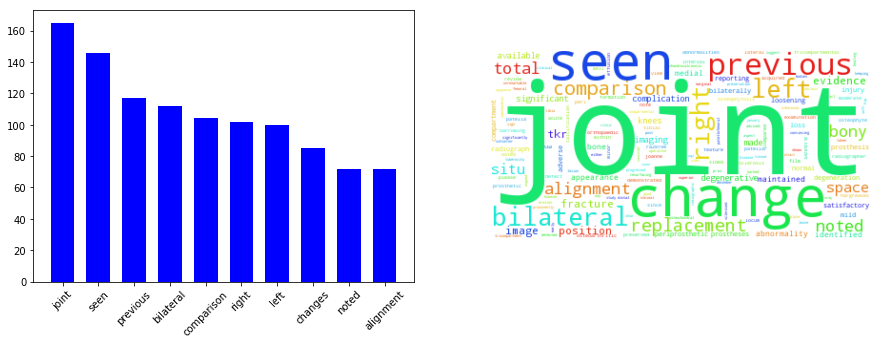

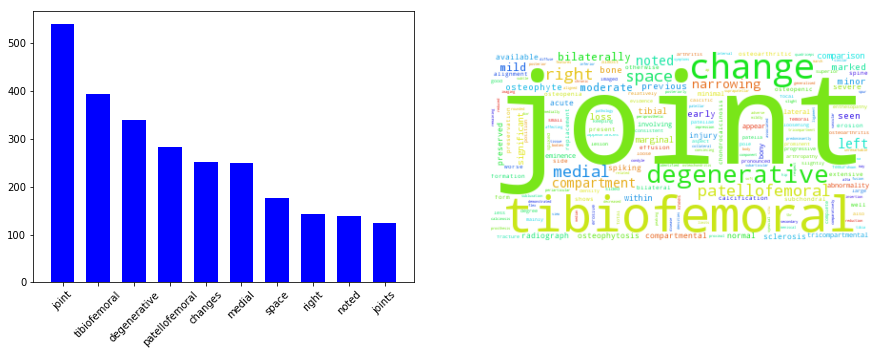

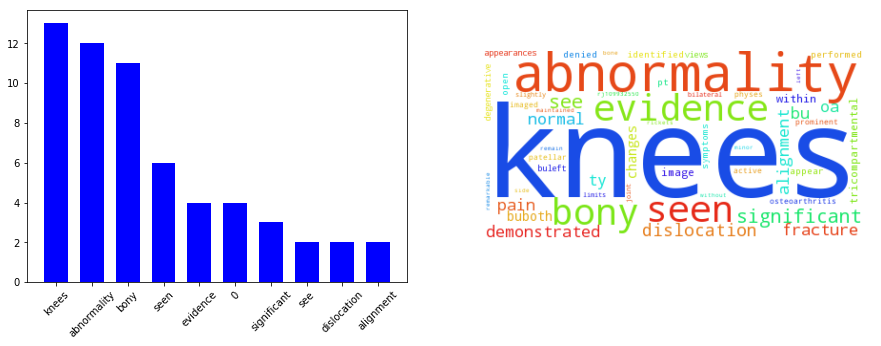

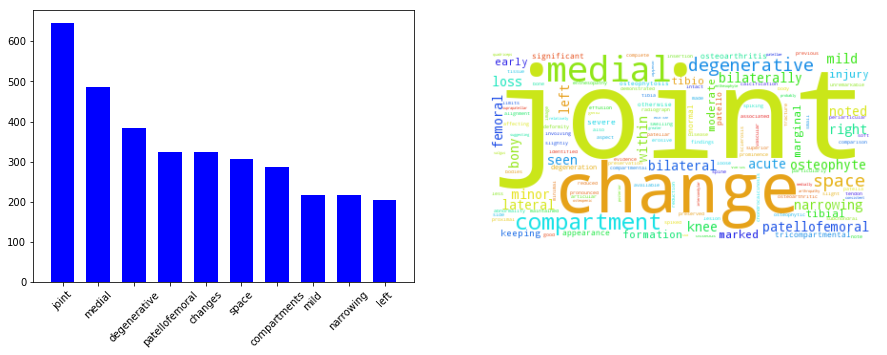

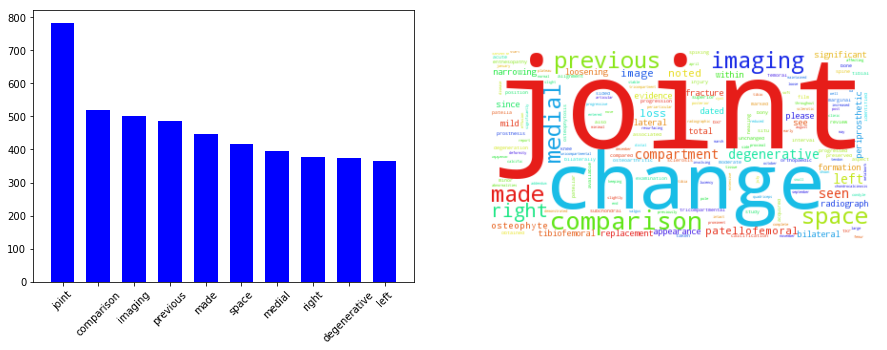

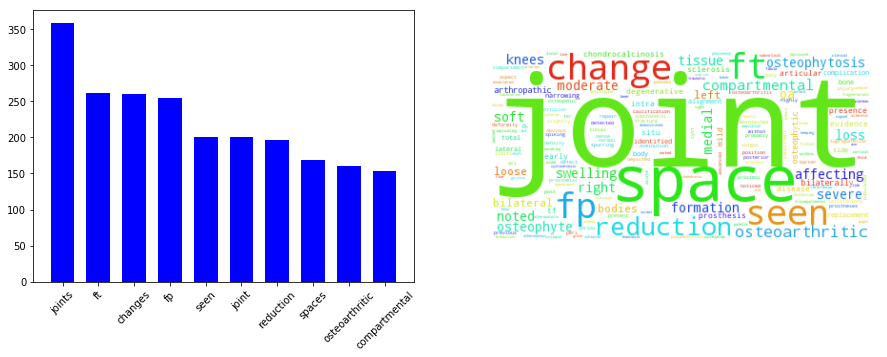

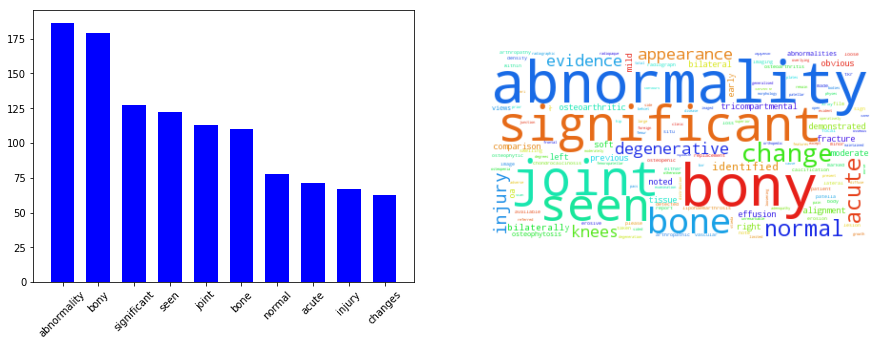

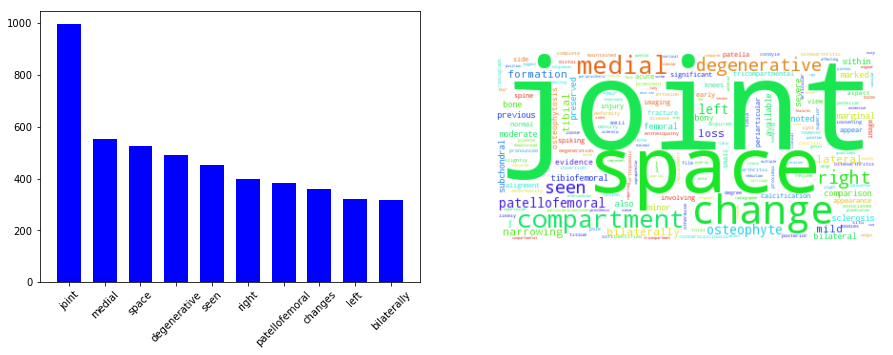

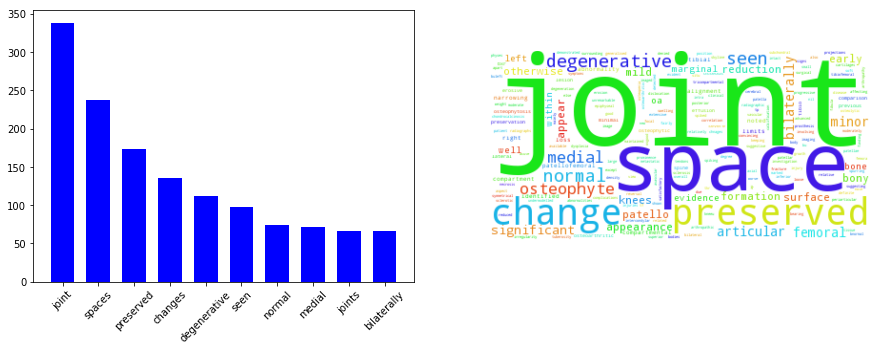

In [40]:
# Visualise words in clusters
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
%matplotlib inline

mystoplist = ['xr', 'knee', 'both', 'x-ray', ':', '.', ',']
stoplist = mystoplist + stopwords.words('english')

visualise_word_clusters2(clusters_is, stoplist)


## 2.7 PCA of clusters

<IPython.core.display.Javascript object>


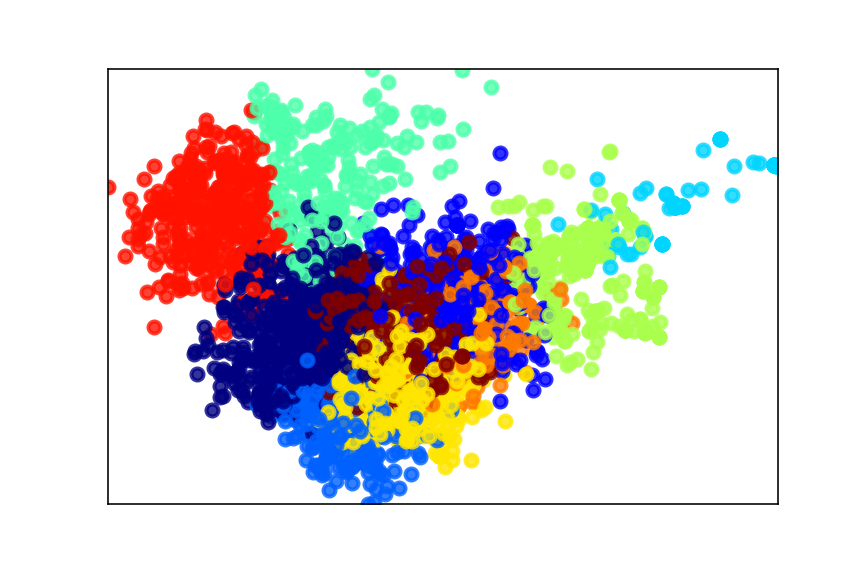

In [22]:
# Plot reports and clusters using PCA
#pylab.rcParams['figure.figsize'] = (18, 10)
pd.options.display.max_colwidth = 4000
%matplotlib notebook
%matplotlib notebook

num_samples_pca = len(reports)
report_samples_linebreaks = []
for report in reports:
    words = report.split()
    new_r = []
    for i, word in enumerate(words):
        new_r.append(word)
        if i%15==0:
            new_r.append(' \n ')
    report_samples_linebreaks.append(' '.join(new_r))

plot_pca(embeddings_is, report_samples_linebreaks, kmeans_labels_is, num_clusters_is, num_samples_pca, print_text=False)

## 2.8 Explore reports in clusters
1. __Cluster 0__ has a high occurance of the phrases *'comparison made'*, *'comparing previous'*, *'changes seen since'*; which suggests this cluster of reports all make reference to previous exams. Looking closely at the reports, it becomes clear that these phrases sometimes explicitly refer to a particular exam (such as *'comparison made images dated 14 , 05 , 2015'*), but sometimes implicitly (*'appearances progressed significantly since 2013'*). However, all the reports make reference to time (year or date)

2. __Cluster 1__ has a high occurance of empty reports, and reports with the word 'abnormality'

3. __Cluster 2__ has a high occurance of words *'mild'*, *'moderate'*, *'minor'*, *'early'* when referring to *'degenerative change'*

4. __Cluster 3__ has a high occurance of the phrases *'osteoarthritic changes'*, *'joints osteophyte formations'* and *'reduction joint space'*

5. __Cluster 4__ has a high occurance of the word *'bony'* as an adjective for *'abnormality'* and *'normal appearance'*

6. __Cluster 5__ has a high occurance of the word *'prosthesis'*

7. __Cluster 6__ is a collection of the longest reports with a combination of pathologies

8. __Cluster 7__ has a high occurance of the phrase *'joint space'*

9. __Cluster 8__ also has a high occurance of the phrases *'comparison made'* and *'previous images'*, however, most do not contain any references to specific dates/years

10. __Cluster 9__ also a collection of long reports with many pathologies, but most (if not all) contain the phrases *'comparison made'* with references to specific dates/years

# 3. Higher level filtering
Phrases that compare previous images are not particularly helpful in determining relevant image-features-text correspondance of this particular exam (unless we have access to the previous exams). Since we do not, these phrases can be filtered out.
In addition, reports with no words can be filtered out.

In [64]:
import re

hl_filtered_reports = []
for report in reports:
    # filter out 'comparison' + dates
    re.sub('( compar.*?\d{4})', '', report)
    re.sub('(xr knee both)', '', report)
    re.sub('(xr knee)', '', report)
    hl_filtered_reports.append(report)


## 3.1 Re-clustering filtered reports

Nb words kept : 97107/98907 (98.18 %)
Speed : 455.59 sentences/s (gpu mode, bsize=128)
nb sentences encoded : 3576


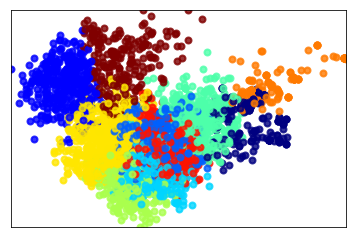

In [65]:
# Generate new InferSent embeddings
new_embeddings_is = model_is.encode(hl_filtered_reports, bsize=128, tokenize=True, verbose=True)
print('nb sentences encoded : {0}'.format(len(embeddings_is)))

# Cluster documents using K-means
num_clusters_is = 10
new_kmeans_labels_is = kmeans_clustering(new_embeddings_is, num_clusters_is)

# PCA
num_samples_pca = len(new_embeddings_is)
plot_pca(new_embeddings_is, reports_linebreaks, new_kmeans_labels_is, num_clusters_is, num_samples_pca, print_text=False)

In [66]:
# Save new clusters to json
filename = 'kmeans_clusters_filtered_infersent.json'
save_clusters_to_json(labels, reports, kmeans_labels_is, num_clusters_is, filename)

In [67]:
# Load clusters from json
clusters_is_fil = load_clusters_from_json('kmeans_clusters_filtered_infersent.json')

Reports in cluster8 112

Reports in cluster9 330

Reports in cluster2 325

Reports in cluster3 64

Reports in cluster0 649

Reports in cluster1 511

Reports in cluster6 283

Reports in cluster7 414

Reports in cluster4 580

Reports in cluster5 308



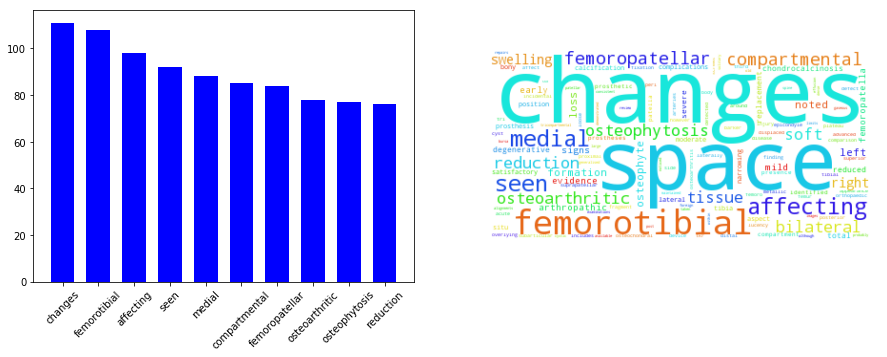

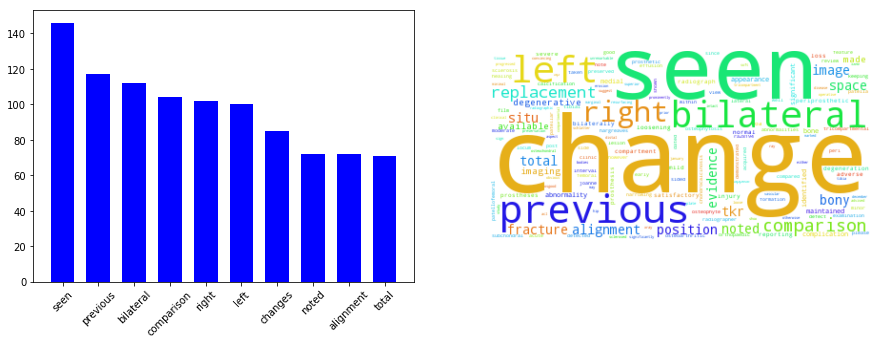

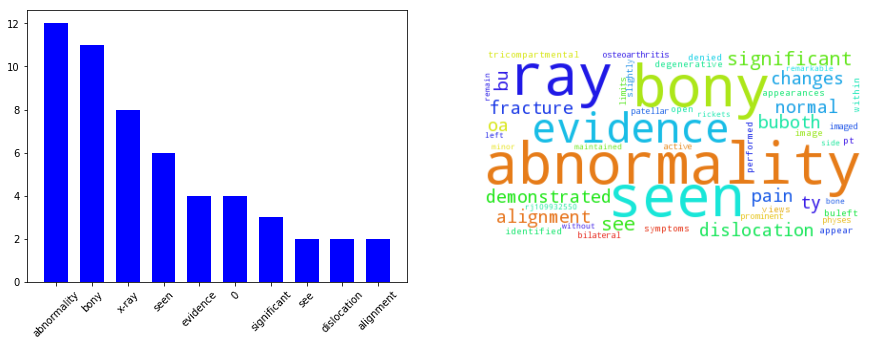

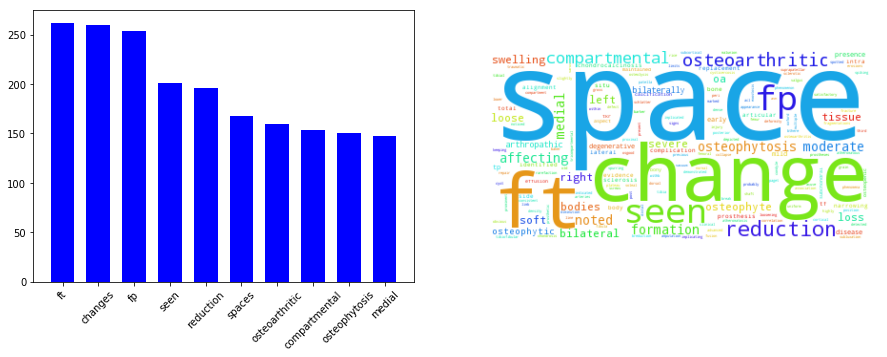

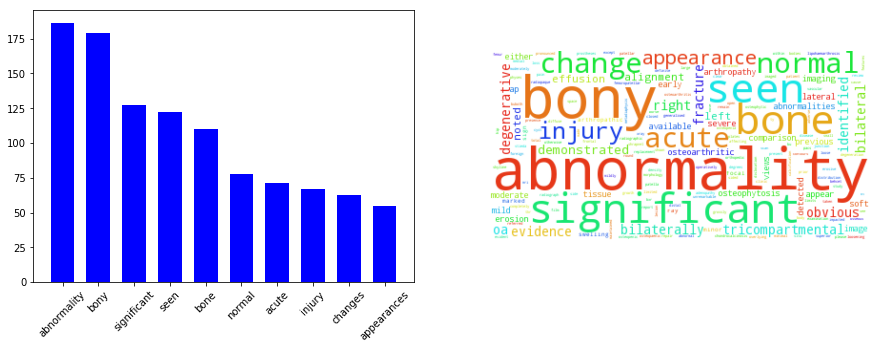

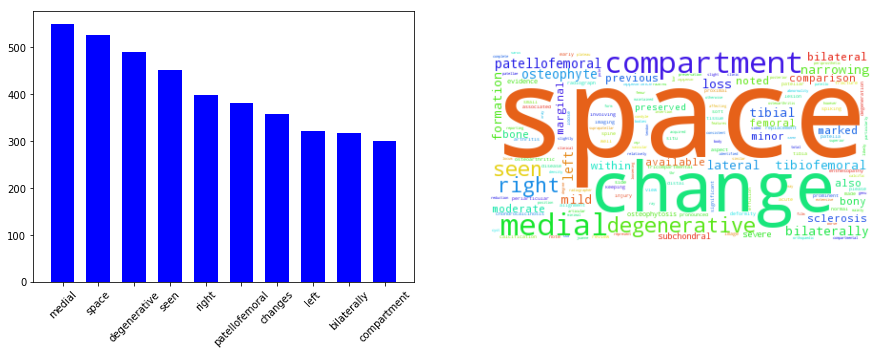

In [68]:
%matplotlib inline

mystoplist = [':', '.', ',', 'knee', 'knees', 'xr', 'joint', 'joints']
stoplist = mystoplist + stopwords.words('english')

visualise_word_clusters2(clusters_is_fil, stoplist)

In [69]:
import pprint
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(clusters_is_fil['cluster3'])

{   u'RJ109665091': u'knee x-ray',
    u'RJ109666483': u'bony abnormality seen',
    u'RJ109687073': u'significant bony abnormality identified',
    u'RJ109687197': u'x-ray knees',
    u'RJ109691767': u'xr knee . .',
    u'RJ109702593': u'xr knee . see',
    u'RJ109703992': u'xr knee . see',
    u'RJ109724355': u'evidence fracture dislocation .',
    u'RJ109729749': u'bony abnormality',
    u'RJ109736514': u'x-ray knees',
    u'RJ109740202': u'imaged - pt denied symptoms',
    u'RJ109742321': u'x-ray knees',
    u'RJ109743205': u'0',
    u'RJ109743526': u'0',
    u'RJ109753227': u'x-ray knees',
    u'RJ109753887': u'0',
    u'RJ109756769': u'bony abnormality seen',
    u'RJ109764381': u'x-ray knees',
    u'RJ109765654': u'x-ray knees',
    u'RJ109793573': u'bony abnormality',
    u'RJ109799610': u'evidence fracture dislocation .',
    u'RJ109801027': u'significant bony abnormality seen',
    u'RJ109802781': u'. .',
    u'RJ109806007': u'knees',
    u'RJ109813348': u'xr knee .',
    u'R

Smallest cluster contains reports with little or no text. Going back to the original csv, it looks like some reports were not extracted correctly, whilst others did indeed have no text. The ones with no text can be removed, and the ones that were not extracted correctly were manually edited in.

In [114]:
df_new = pd.read_csv(dir + 'cleaned_reports_edited.csv')
print df.loc[df['Accession'] == 'RJ110742290']

        Accession  \
3117  RJ110742290   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     Clinical history  \
3117  Entered by: Duncan Rogers\nRequested by: Duncan Rogers\nClinical Details: bilatearl groin pain, and knee pain, reduced internal rotation bilaterally\nQuestion/s: ? osteeoarth

In [98]:
# Basic filtering and stats
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import numpy as np
import random
import re
random.seed(123)
np.random.seed(123)

reports = []
reports_tok = []
labels = []
words = []
for i, row in df_new.iterrows():
    report = str(row['Report text']).decode('utf-8').lower()
    print report
    if report.isalnum:
        # Replace unnecessary punctuation 
        for char in ['~', '"']:
            report = report.replace(char, '')
        
        for char in ['!', '?', ';', ':', '.']:
            report = report.replace(char, ' . ')
    
        for char in ['(', ')', ',', '/']:
            report = report.replace(char, ' , ')
        
        # Tokenize
        report_tok = word_tokenize(report)
    
        # Remove stopwords
        filtered_report_tok = [word for word in report_tok if word not in stopwords.words('english')]
        filtered_report = ' '.join(filtered_report_tok)
    
        reports.append(filtered_report)
        reports_tok.append(filtered_report_tok)
        labels.append(row['Accession'])
        [words.append(word) for word in filtered_report_tok]
    else:
        print report

print 'Vocab length: ', len(sorted(set(words)))
print 'Avg no. of appearances: ', len(words)/len(sorted(set(words)))
fdist_all = nltk.FreqDist(words)
freqs = [freq for _, freq in fdist_all.most_common()]
print 'STD: ', np.std(freqs)
#print fdist_all.hapaxes()
print 'Number of reports: ', len(reports)

xr knee both :
screw fixation is seen at the tibial tuberosities bilaterally. minor osteophyte formation is seen at the tibiofemoral joints bilaterally otherwise the joint spaces are preserved. there has been a patellectomy on the right. minor degenerative changes are seen at the left patellofemoral joint and there is patella alta.
both knees: there is moderate oa change to the medial compartments of both knee joints causing mild varus angulations. nil else of note.
xr knee both : 
orthopaedic clinic review imaging.

there severe degenerative changes seen bilaterally within the patellofemoral joints marked by significant sclerosis and joint space narrowing.

there are moderate degenerative changes seen within the other compartments bilaterally. these are marked by tibial spiking, osteophytosis and subarticular sclerosis. comparatively the media and lateral joint spaces are relatively well preserved.
xr knee both :
there is a right total knee replacement in situ. no evidence of any peri

xr knee both : moderate degenerative changes are noted in both tibiofemoral joint and both patellofemoral joint, more marked on the right.
xr knee both : degenerative changes in the right patello femoral and tibio femoral joint marginal osteophytes and narrowing of medial tibio femoral joint space.
minor changes are seen in left knee joint. joint spaces are preserved.
xr knee both : 

bilaterally there is minor joint space narrowing within the medial and patellofemoral compartments with associated osteophyte formation.
xr knee both : minor degenerative change noted in  both tibiofemoral joints and both patellofemoral joints more marked on the right. chondrocalcinosis in  both tibiofemoral joints.
xr knee both : 

normal bony appearances.  no bone erosions.
xr knee both : no abnormality.
xr knee both : no abnormality seen. no erosive arthropathy seen.
xr knee both : bones are osteopaenic. no significant joint abnormality.
xr knee both : comparison has been made with the previous of 6 ja

xr knee both : minor degenerative changes are noted in both tibiofemoral joint and both patellofemoral joint more marked on the right.
xr knee both : degenerative changes patello femoral and tibio femoral joints bilaterallly with marginal osteophytes.
joint spaces are preserved.
xr knee both : early minor degenerative changes are noted in both tibiofemoral joints with  spiking of tibial eminence and slight medial compartmental joint space narrowing more marked on the left. both patellofemoral joints appear  normal.
xr knee both : 

comparison is made with radiograph dated 6 january 2015.
note is made of bilateral tkr. position and alignment is as demonstrated.
no bony or other abnormalities are seen.
xr knee both : no bone or joint abnormality.
xr knee both : no significant bone or joint abnormality.
xr knee both : 

there is normal alignment. there is mild joint degeneration in the medial compartments bilaterally with some minor loss of joint space.

note is made of calcific enthesopa

xr knee both : 

comparison is made with the imaging obtained on 25/10/2013.

imaging acquired for orthopaedic clinic review.

there is tricompartment degenerative change bilaterally. appearances are most pronounced within the medial tibiofemoral compartment in joint space narrowing and periarticular osteophyte formation.
xr knee both : both knees, 2 views, compared to october 9, 2014. distal femoral, proximal tibial epiphysiodesis plates bilaterally appear unchanged in position. the hardware appears intact the physes bilaterally appears similar to the prior. bowing of bilateral distal femora again noted.
xr knee both : 

right knee:  no bone abnormality seen. 

left knee:  no bone abnormality seen
xr knee both : 

there was mild patellofemoral and tibiofemoral medial compartment degenerative change bilaterally.
xr knee both : there is bilateral tricompartmental degenerative change, moderately severe on the left and moderate on the right.
xr knee both : 

imaging acquired of the left k

xr knee both : minor degenerative changes are noted in both tibiofemoral joint and both patellofemoral joint. chondrocalcinosis noted in the right tibiofemoral joint. no joint effusion seen.
xr knee both : 

there is mild degenerative change related to the medial and patellofemoral joint compartments bilaterally with some loss of joint space and minor periarticular osteophyte formation.  the changes are most pronounced on the left.
mild osteoarthritic changes in the right knee with medial joint space narrowing. minimal degenerative changes in the left site.
xr knee both : 

the joint spaces and articular surfaces appear preserved.  no significant degenerative or erosive change seen
no bony abnormality is seen
~bxr knee right :~b 

comparison is made with imaging from 29/01/2015.

the previous total knee replacement is again noted. there is no evidence of periprosthetic fracture or prosthesis loosening.
please see images for position and healing.


~bxr knee left : ~b

comparison is mad

xr knee both : 
there are degenerative changes seen bilaterally with tricompartmental joint space narrowing, osteophyte formation and sclerosis. joint space narrowing is most marked on the right medial compartment.
xr knee both : 
the images available for comparison.
there are degenerative changes seen bilaterally with joint space narrowing, sclerosis and osteophyte formation. joint space narrowing is most marked in on the right side medial compartment.
xr knee both : degenerative changes are seen in both knees with narrowing of all 3 joint compartments, particularly the patellofemoral joint, and on the left there is osteophyte formation. all 3 joint space components of both knees are still preserved.
xr knee both : 

ap & lateral left knee and skyline views of both knees.

comparison to previous radiograph of 3 december 2007. overall unchanged appearances of the degree of joint space loss in the medial tibiofemoral compartment. minor loss of joint space laterally within both patellofe

xr knee both : degenerative changes with marginal osteophytes medial tibiofemoral joint space and patellofemoral joint space. joint spaces are preserved.
xr knee both : 
left knee
knee replacement noted, no change is seen when compared with the previous study of 29/01/15.
right knee
revision knee replacement noted, no change is seen when compared with the earlier study of 29/1/15.
xr knee both : 
no bony abnormalities identified.
xr knee both : minor degenerative changes patello femoral joint with marginal osteophytes.
joint spaces are preserved.
xr knee both : left tkr, good alignment. no adverse features. there is moderate oa change to the right patellofemoral joint and to a lesser extent in the medial compartment of the right knee joint. alignment maintained.
xr knee both : there is severe oa change in the medial compartment of both knee joints, and to a lesser extent in the patellofemoral joints. the right is marginally worse than the left.
xr knee both : 

there is minor early pat

comparison is made with previous radiograph dated 17 aug 2014. 
no significant interval changes.

there are tricompartmental degenerative  osteoarthritic changes more marked at the patellofemoral joints with joint space narrowing, osteophyte formation  and subchondral sclerosis.
no acute bony injury.
xr knee both : 

no significance bony abnormality.
xr knee both : 

no significant bony abnormality.
xr knee both : 

there is moderate left and mild right knee diffuse tricompartmental degenerative change.  there is modelling deformity to the anterior tibia proximally presumably due to a previous fracture.
xr knee both : 

there is a moderate tricompartmental degenerative change.
xr knee both : no bone or joint abnormality.
xr knee both : 

there are minor degenerative changes within the patellofemoral compartment of the left knee and there are moderate degenerative changes within the right knee, seen most extensively within the patellofemoral compartment. there is faint meniscal calcific

xr knee both : 

there is minimal early patellofemoral and tibiofemoral medial compartment degenerative change only.
xr knee both : 

there is evidence of moderate to severe degenerative arthritis involving both knee joints most prominently within the right medial tibio-femoral compartment where there is significant loss of joint space. similar appearances, although slightly less marked, are noted on the left. there is prominent degenerative arthritis involving the patellofemoral joint spaces bilaterally, again worse on the right.
no previous radiographs available for comparison.

there is bilateral tricompartmental mild degenerative osteoarthritic changes with osteophytosis.
no acute bone injury.
no erosion.
xr knee both : 

right:
there is marked loss of joint space at the medial tibiofemoral joint with subchondral sclerosis and osteophyte formation. minor joint space loss is seen at the lateral and patellofemoral compartments. there is evidence of chondrocalcinosis and soft tissue c

xr knee both : 

no previous reversal of comparison.
no significant degenerative changes seen. preservation of joint space in both knees.
xr knee left: 

comparison is made with imaging from 18/11/2013.

there is some mild degeneration of the patellofemoral and medial compartments of the left knee with some loss of joint space. 



xr knee right: 

comparison is made with imaging from 20/01/2014.

the previous total knee replacement is again noted. 

there is no evidence of periprosthetic fracture or prosthesis loosening.

please see images for position and healing.
xr knee left :

comparison is made with imaging from 5/3/13.

the previous longstem total knee replacement is again noted. 

there is no evidence of periprosthetic fracture or prosthesis loosening.

please see images for position and healing.




xr knee right : 

comparison is made with imaging from 5/3/13.

the previous longstem total knee replacement is again noted. 

there is no evidence of periprosthetic fracture or pr

xr knee both :
moderate degenerative changes are seen at the patellofemoral compartments bilaterally with narrowing of the joint space and marginal osteophytes. there is minor joint space narrowing of the medial compartments with small marginal osteophytes seen.
xr knee both : 

there is moderate patellofemoral joint degenerative change bilaterally.  there is mild bilateral tibiofemoral joint degenerative change.  on the right, there is a large well-corticated calcific density adjacent to the tibial tuberosity which may represent an old avulsion injury/osgood-schlatter's disease.
xr knee both : 

there are no previous images available for comparison.

the bones are osteopenic.

there is bilateral moderate joint degeneration of the medial and patellofemoral compartments, with loss of joint space and osteophytosis. there is no radiographic evidence of bony erosions.
xr knee both : the cerebral changes patellofemoral joint and marginal osteophytes. joint spaces are preserved.
xr knee both

xr knee left :

comparison is made with imaging from 19/12/2013.

the previous total knee replacement is again noted. 

there is no evidence of periprosthetic fracture or prosthesis loosening.

please see images for position and healing.




xr knee right : 

comparison is made with imaging from 20/03/2013.

the minor degenerative change seen in the patellofemoral and medial knee compartments is again noted.
xr knee both : 

there is minor early tricompartmental degenerative change bilaterally. there is mild calcific enthesopathy involving the superior poles of the left patella.
~bxr knee left: ~b

there are no previous images available for comparison.

there is a total knee replacement in situ.

there is no evidence of periprosthetic fracture or prosthesis loosening.

please see images for position and healing.

~b
xr knee right: ~b

there are no previous images available for comparison.

there is moderate joint degeneration of the medial compartment with loss of joint space, subchond

xr knee both : 

there are no previous x-rays available for comparison.

there is tricompartmental joint degeneration, with loss of joint space, osteophytosis and chondrocalcinosis. the appearances are more severe on the left lateral compartment of the knee.
there is no radiologic evidence of bone abnormality, osgood-schlatter or suprapatellar fluid collection.
the knee alignment is maintained bilaterally.

t youssef
xr knee both : degenerative changes patello femoral and tibio femoral joint with loss of patello femoral joint space and reduced medial tibio femoral joint space..
comparison is made with previous radiograph dated 25 sept 2013.
no significant interval changes.

there are moderate bilateral tricompartmental degenerative osteoarthritic changes with osteophyte formation, join space narrowing and subchondral sclerosis. more at the right side.
no acute bony injury.
xr knee both : 

no previous imaging available for comparison.
previous left mri knee examination completed.

bila

xr knee both : the severe degenerative changes of the medial tibiofemoral joints of the knees bilaterally with complete loss of joint space, subchondral sclerosis with multiple small subchondral cysts and marginal osteophyte formation. a moderate genu varus deformity is seen bilaterally.
there is relative sparing of the lateral joint spaces.
moderate degenerative changes are seen in the patellofemoral compartments bilaterally.
xr knee both : 

images taken for orthopaedic clinic review.
comparison is made with images dated 8/8/15.
there are bilateral total knee replacements in situ.
no periprosthetic fractures are identified.
no significant change since previous imaging.
please images for post-operative position.
xr knee both : 
ap and lateral views of the right knee. persistent patella alta. the osteochondral defects are no longer visualised. no evidence of fracture or morphologic abnormality.
xr knee both : 
no bone, joint or soft tissue abnormality identified.
xr knee both : moderat

the previous similar radiograph is available for comparison.

there is bilateral tricompartmental degenerative osteoarthritic changes. particularly severe at the medial knee compartment. with complete loss of the medial knee joint space, subchondral sclerosis and osteophytosis.
xr knee right : 

comparison is made with imaging from 20/7/2011.

the joint degeneration of the medial and patellofemoral compartments is again seen.


xr knee left : 

comparison is made with imaging from 23/07/2014.

their is some mild joint degeneration of the medial compartment, with loss of joint space.
xr knee both : minor degenerative changes in the patellofemoral joint remains static on comparing with previous of july 2010.
there are ossified bodies in the infrapatellar region within the right anterior joint compartment not seen on the previous x-ray of july 2010 ? synovial osteochondromatosis.
xr knee both : 

comparison is made with the examination of 19/9/14.

there is mild bilateral medial and patel

xr knee both : 

there are no previous images available for comparison.

there is severe tricompartmental joint degeneration with loss of joint space, osteophytosis and subchondral sclerosis.
xr knee both : 

comparison is made with imaging from 1/7/14.

there is severe tricompartmental joint degeneration of the left knee and moderate tricompartmental joint degeneration of the right knee. the appearances have progressed with further loss of joint space, osteophytosis and subchondral sclerosis.
xr knee both : no bone or joint abnormality.
xr knee both : 

comparison is made with imaging from 15/6/15.

the previous bilateral total knee replacements are again noted. 

there is no evidence of periprosthetic fracture or prosthesis loosening.

please see images for position and healing.
xr knee both : 

the joint spaces appear preserved bilaterally.  there is minor osteophyte formation noted from the posterior aspects of both patellae.
an addendum has been entered at the end of this report
x

xr knee both : 

no acute fracture or dislocation. the joint space is preserved. there are very early osteoarthritic changes.
xr knee both : 

there is a left knee joint effusion. no acute bony injury demonstrated.
xr knee both : 

normal bony appearances.
xr knee both : 

the bilateral joint degeneration of both knees is again noted and appears to have progressed since previous imaging, most prominently in the medial compartments.

please see images for position.
xr knee both : 

the joints spaces and articular surfaces are preserved.
no previous radiograph is available for comparison.

there is early degenerative osteoarthritic changes with mild narrowing of the medial tibiofemoral compartment bilaterally. this associated with minimal osteophytosis.
no acute bone injury.
xr knee both : 

there is varus deformity seen to both knees bilaterally. this is slightly more prominent on the left knee. and no other bone abnormalities seen.
xr knee both : 
no significant bony abnormality seen.


xr knee both : 

there is mild narrowing of the medial joint compartment bilaterally. osseous appearances within normal limits.
xr knee both : 

comparison is made with the imaging obtained on 07/07/2014 for the right knee, no comparison available for the left knee.

imaging acquired orthopaedic clinic review.

there are mild degenerative changes noted within the medial and patellofemoral joint spaces bilaterally.

alignment is preserved.
xr knee both : mild oa changes seen in the medial compartments of both knee joints where there is loss of cartilage space. nil else of note.
xr knee both : 

comparison is made with the imaging obtained on 24/06/2014.

there are bilateral total hip replacements in situ. no radiographic evidence of periprosthetic fracture or loosening. no interval change identified.
comparison is made with a previous right knee radiograph dated 9 september 2013.

there is old healed lateral tibial plateau fracture. there is a minimal compression the right lateral tibia

xr knee both : no significant bone or joint abnormality.
no sign of oa.
xr knee both : degenerative changes patello femoral and tibio femoral joint with narrowing of medial tibio femoral joint space.
xr knee both : 

there is osteoarthritic change of both knee joints more marked on the right side with bilateral joint space narrowing and osteophyte formation.  the patellofemoral joints are mildly effected but there is no chondrocalcinosis.  bilateral oa confirmed.
xr knee both : 

right knee: no acute bony injury seen. no lipohaemarthrosis or joint effusion seen. mild degenerative changes seen throughout but specifically joint narrowing seen within the medial compartment. chondrocalcinosis is noted.

left knee: no acute bony injury seen. no lipohaemarthrosis identified or joint effusion seen. mild degenerative changes seen throughout but specifically joint narrowing at the medial compartment.
xr knee both :


left knee:
comparison made with imaging from 20th of january 2008.
left total 

x-ray both knees.

minor bilateral patellofemoral joint osteoarthritis is seen, worse on right than left. good preservation of both medial lateral joint space.

x-ray right foot.

no significant bony abnormality is seen.

x-ray right foot.

normal examination.

x-ray both hands.

comparison is made with the previous examination october 2014.
no erosive changes are seen. normal bone density.
xr knee both : there are mild tricompartmental degenerative changes bilaterally.
no previous radiographs available for comparison.

there is preservation of the joint space within the tibiofemoral and patellofemoral joints bilaterally.
no erosion. no degenerative changes.
xr knee both : mild degenerative changes in the medial compartments bilaterally with joint space narrowing and subchondral sclerosis.
normal appearances of the patellofemoral joints.
xr knee both : there is severe degenerative change of the left knee with complete loss of the medial joint space. moderate genu varus deformity is see

xr knee both : no interval change is seen and compared with the earlier study of 8/5/14. there are sclerotic change noted in  both tibiofemoral joint and both patellofemoral joint, most likely represent degenerative change. no plain radiographic evidence of avascular necrosis seen.
xr knee both : moderate degenerative changes are noted in both tibiofemoral joints and both patellofemoral joint. there are soft tissue calcifications noted in the posterior aspect of the both knee joint. ?synovial calcification.
xr knee both : 

normal alignment. no acute bony injury.
there is mild loss of joint space within the medial compartments bilaterally suggesting early degenerative change.
x-ray both knees

there is symmetrical joint space narrowing the medial compartment of both knees with chondrocalcinosis. mild patellofemoral joint osteophyte formation is seen.
xr knee both : left-sided total knee replacement in situ with satisfactory alignment of femoral and tibial components.
no adverse feature

~b~ufindings: comparison is made to previous exam in 03/2013 and 10/2014~b~u
there is interval ossification of the patellae, more prominent on the left.
there is remodelling of the distal femoral shafts.
there remains markedly metaphyseal widening and irregularity with poorly ossified femoral capital epiphyses.
an accessory ossification centre is seen at the distal left femoral epiphysis.
irregularity of the subchondral margins of the acetabula, ischia and pubic bones are also noted.

measurements (including the cartilaginous femoral heads)
lt femur= 19.1cm   rt femur= 18.8cm
lt tibia= 14.7cm   rt tibia= 14.3cm


t youssef
xr knee both : no acute bony injury is seen. there is minor narrowing of the medial joint space compartments but both medial, lateral and patellofemoral joint space compartments are preserved.
xr knee both : mild to moderate degenerative changes are noted in both tibiofemoral joints and both patellofemoral joint more marked on the left.
xr knee both : 
right knee
chr

xr knee both : moderate degenerative changes noted in both patellofemoral joint.  minor degenerative changes noted in both tibiofemoral joint.
xr knee both : 
left knee
fusion of the tibiofemoral joint seen. severe degenerative change noted in the patellofemoral joint.
right knee
chronic severe degenerative changes are noted in the tibiofemoral joint and patellofemoral joint with almost complete loss of joint space.
xr knee both : 

there is tricompartmental degeneration.
xr knee both : 

no previous imaging available for comparison.

imaging acquired for orthopaedic clinic review.

there is minor joint space narrowing of the medial tibiofemoral and patello femoral joints bilaterally.

the lateral tibiofemoral compartment appears preserved.

i note at the time of this report the patient has been referred to mri for a right knee scan. please see subsequent imaging an associated report.
~bxr knee both : ~b

there is minimal loss of joint space related to the medial joint compartments bil

xr knee both : 

comparison is the imaging obtained on 04/11/2014.

imaging acquired for orthopaedic clinic review.

there is degenerative change within the medial joints bilaterally with joint space narrowing, sclerosis and osteophyte formation.

there is mild patellofemoral compartment degenerative change.
~bxr knee right : ~b

comparison is made with imaging from 06/11/2013.

the previous total knee replacement is again noted. 

there is no evidence of periprosthetic fracture or prosthesis loosening.

please see images for position and healing.


~bxr knee left : ~b

comparison is made with imaging from 11/06/2012.

the joint degeneration of the medial and patellofemoral compartments is again noted and has progressed since previous imaging, with further loss of joint space and osteophytosis.
~bxr knee right: ~b

there are no previous images available for comparison.

there is tricompartmental joint degeneration with loss of joint space and osteophytosis, most prominently in the medi

right knee
comparison is made with the previous radiograph dated 11 december 2012 for the right knee.

unicompartmental knee replacement is noted. please see film, unchanged since the previous radiograph.
there is complete resolution of the lipohemarthrosis noted on the previous radiograph.
there is mild degenerative osteoarthritic changes within the patellofemoral joint with osteophytosis.
no acute bone injury.

left knee
no previous similar radiograph available for comparison.

there is mild degenerative osteoarthritic changes within the medial tibiofemoral compartment with mild narrowing, and patellofemoral compartment with osteophytosis.
there is mild suprapatellar joint effusion.
there is mild enthesopathy within the superior pole of the patella at the attachment of the quadriceps tendon.
x-ray both knees

no bony abnormality
comparison is made with a previous radiograph dated to october 2014.

there is stable appearance of the mild tricompartmental degenerative osteoarthritic cha

xr knee both : 

there are mild bilateral degenerative changes, most marked within the patellofemoral compartments of both knees. the appearances have progressed since the previous examinations of 11/9/07.
xr knee both : 

there is degenerative change bilaterally with loss of joint space and periarticular osteophyte formation involving the medial and patellofemoral joint compartments.  chondrocalcinosis is noted in the lateral joint compartments bilaterally also.
there is spiking of the tibial spines. there is good preservation of both medial and lateral joint spaces. there is moderate symmetrical patellofemoral joint osteoarthritis, worse on the right than the left.
xr knee both : 

left knee: there are severe medial tibiofemoral degenerative change is noted.

right knee: there is severe medial tibiofemoral joint degenerative changes noted
xr knee both : 

right knee: there is degenerative changes noted to the medial tibiofemoral joint with tibial eminence spiking.

left knee: minimal

xr knee both : 

the joint spaces are preserved bilaterally.  there is mild prominence at the tibial spines, especially on the left, suggestive of early degenerative change.  imaged bones are otherwise unremarkable.
xr knee both : there is mild diffuse tricompartmental degenerative change on the right more marked in the patellofemoral joint. there is little degenerative change on the left. no bone erosions.
xr knee both : 

as seen previously, there is mild calcific enthesopathy involving the superior pole of the patella and the patellar tendon insertion into the tibial tuberosity seen bilaterally.  the joint spaces are preserved.  no radio-opaque intra-articular loose body is demonstrated.
no previous radiographs available for comparison.

no significant degenerative changes.
no erosion.
no acute bone injury.
xr knee both : 

right knee:  there is degenerative changes noted in all 3 compartments of the knee.  this is the most prominently seen in the patellofemoral joint. 

left knee: 

xr knee both : 

there is marked narrowing of both medial joint compartments.  these appearances have not progressed significantly since december 2011.
xr knee both : extensive progressive  degenerative changes patello femoral and tibio femoral joint on the left with loss of joint space on comparing with previous of 8/10/2008/.

on the right there are significant degenerative changes patello femoral and tibio femoral joint with osteophytosis and narrowing of joint space.
xr knee both : there is mild to moderate degenerative change in the medial and patellofemoral compartments bilaterally, with joint space narrowing and subchondral sclerosis.
only minor  osteophyte formation is seen marginally.
the patellar alignment appears normal.
normal appearances of the knees, no cause for pain identified.
xr knee both : 

comparison is made with imaging from 4/11/14.
there is moderate tricompartmental joint degeneration bilaterally, with some loss of joint space and some marginal osteophytosis.
~b

no previous radiographs available for comparison.

there is ossification adjacent to the margin of the right medial femoral condyle at the medial femoral collateral ligament, appearances are in keeping with pellegrini-stieda lesion.
patellofemoral joint space and tibiofemoral joint spaces are preserved bilaterally.
no significant degenerative changes.
comparison is made with the previous radiograph dated 29 december 2014.
no significant interval change.

there is stable appearance of the early degenerative changes with mild narrowing of the medial compartment of both tibiofemoral joint.
there is bone fragment loose body within medial compartment of the right knee joint associated with irregular tibial spine, avulsion fracture?.
there is early degenerative changes within the patellofemoral joint bilaterally with osteophytosis. the joint space is still preserved. normal trochlear groove.
xr knee both : 

there is mild joint space narrowing of the medial compartment of both knees and mild

comparison is made with a previous radiograph dated 15 september 2011.

there is severe tricompartmental degenerative osteoarthritic changes with complete loss of the joint spaces and marked osteophytosis and subchondral sclerosis.
no acute bone injury.
xr knee both : the bones are osteopenic. minor degenerative changes patellofemoral joint with marginal osteophyte. joint spaces are preserved.
xr knee both : mild to moderate degenerative changes in the left knee joint.
moderate to severe degenerative changes medial tibio femoral and patello femoral joint with reduced m medial tibio femoral joint space.
xr knee both : no acute bony injury
xr knee both : 

there is mild narrowing of both medial joint compartments.  joint spaces are otherwise preserved.  no osseous abnormality seen.
xr knee both : 

there is complete loss of the medial joint compartments bilaterally with adjacent osteophyte formation.
there is osteophyte formation related to the lateral compartments, however, this joint s

no previous radiograph is available for comparison.

no significant degenerative changes.
no acute bone injury.
xr knee both : 

there is medial and patellofemoral compartment joint space loss with early osteophytosis, in keeping with degenerative change. there is some sclerosis involving the lateral tibial plateau which i presume is degenerative but could be post-traumatic in the correct clinical context.
xr knee both : 

comparison is made with the imaging obtained on 29/02/2012 (right knee only).

there is extensive tricompartment degenerative change bilaterally. 

appearances are most marked within the patellofemoral and medial compartments bilaterally with joint space narrowing and osteophyte formation.

there is prominent new bone formation arising from both femoral condyles which remains unchanged since previous imaging.
xr knee both : 

comparison is made with radiograph dated 14 january 2008.
no bony or other abnormalities are seen.
xr knee both : early degenerative changes ri

xr knee both : 

there is no significant soft tissue swelling, joint effusion or lipohaemarthrosis in either knee. no fracture is demonstrated.
xr knee both : 

comparison is made with radiograph dated 12 october 2010.
there appears to be a well corticated bone fragment overlying the lateral femoral condyle of the right knee.
no other bony or abnormalities are seen.
xr knee both : 

there is severe degenerative change seen in the medial tibiofemoral joint compartment of the left knee and patellofemoral joint compartments of both knees.  moderate degenerative change is seen in the medial and lateral tibiofemoral joint compartments of the right knee.
xr knee both : 

no previous x-ray imaging for comparison.
no bony or other abnormalities are seen.
xr knee both : 

joint spaces are preserved.  imaged bones are unremarkable.  normal alignment is seen.
xr knee both : 
there is bilateral joint space narrowing most marked on the medial compartments.
there is also calcification of the patella

xr knee both : left knee replacement prosthesis is well aligned and in good position. no loosening.
extensive degenerative changes present in the right knee joint with osteophytosis and loss of medial tibiofemoral joint space.
xr knee both : the right knee joint shows progressive degenerative changes and loss of medial tibiofemoral joint space and patellofemoral joint space. the left knee shows minor destructive changes with marginal osteophytes patellofemoral and tibiofemoral joints.
xr knee both : bilateral knee replacement with prosthesis in good position well aligned. no sign of loosening.
xr knee both : early degenerative changes in the left medial tibio femoral joint with marginal osteophytes and reduced joint space.there is also suprapatellar joint effusion.
no significant changes in the right knee joint.
xr knee both : no bony abnormality seen.
xr knee both : there is moderately severe tricompartmental degenerative change bilaterally, with relative sparing of the lateral compar

xr knee both ap and lateral: 

both knees have a normal appearance.
xr knee both : 
no previous radiographs available for comparison.

no significant degenerative change is seen.
no acute bone injury.
xr knee both : 
there is minor joint space narrowing of the medial compartment bilaterally. 
note is made of marked vascular calcification.
xr knee both : 
there is bilateral moderate to severe tricompartmental degenerative changes seen.
this is marked by subarticular sclerosis and osteophytosis.
joint space narrowing is more significant within the medial compartments associated varus deformities.
xr knee both : bilateral minor degenerative changes patellae femoral joint tibio femoral joint with marginal osteophytes slightly more prominent in the right knee joint.
xr knee both : 

left-sided lipohaemarthrosis is suggestive of an intra-articular fracture however no definite fracture is seen.

no right-sided fracture is seen.

discussed with medical registrar.
xr knee both : on the left the

xr knee both : 

comparison is made with imaging from 19/03/2013.

there is severe bilateral tricompartmental joint degeneration, which appears to have progressed since previous imaging, with further loss joint space, osteophytosis and periarticular sclerosis.
xr knee both : 

there is moderate patellofemoral joint degenerative changes bilaterally.  there is mild tibiofemoral compartment degenerative change bilaterally.
xr knee both : 

there is moderate tricompartmental degenerative change bilaterally.  there is marked chondrocalcinosis.  on the right there are what i presume to be calcified loose bodies lying posteriorly within the knee joint or a related bursa.  there is a small suprapatellar joint effusion on the right.  no bone erosions.
xr knee both : 

there are no previous images available for comparison.

there is bilateral tricompartmental joint degeneration most prominently in the medial and patellofemoral compartments with loss of joint space, osteophytosis and subarticular

xr knee both : on the right knee was x-rayed report being symptomatic. no significant bone or joint abnormality.
xr knee both : 

comparison is made with the imaging obtained on 22/11/2013.

imaging acquired for orthopaedic clinic review.

there is significant degenerative change within the tibiofemoral patellofemoral joints bilaterally most marked by joint space narrowing, subchondral sclerosis and osteophyte formation.

no significant change in radiographic appearance since the previous imaging.
~bxr knee right: 
~b
comparison is made with imaging from 11/2/2013.

the medial unicompartmental knee replacement is again noted. the degenerative changes of the lateral and patellofemoral compartments are again seen and have progressed since previous imaging with further loss of joint space and osteophytosis.

there is no evidence of periprosthetic fracture or prosthesis loosening.

please see images for position and healing.


~bxr knee left: ~b

there are no previous images available for 

xr knee both : 
orthopaedic clinic review imaging.
bilaterally the knee joint appear relatively well preserved.
no significant bony abnormality detected
xr knee both : there is tricompartmental oa change to both knees, with complete loss of cartilage space in the medial compartments and florid osteophyte formation. slight varus deformity is developing.

joanne hargreaves
locum reporting radiographer
ra28194
xr knee both : tkr to the left knee. there is severe oa change in all 3 compartments of the right knee joint. there is a slight varus angulation.

joanne hargreaves
locum reporting radiographer
ra28194
xr knee both : 

comparison is made with the imaging obtained on 08/11/2013.

imaging acquired orthopaedic clinic review. there

there bilateral total knee replacements with patellar resurfacing in situ. no radiographic evidence of purposes fracture or loosening.

no interval change identified.
xr knee both : no bone or joint abnormality.
xr knee both : 
there is tricompartmental dege

xr knee both : both knees show cartilage space narrowing in the medial compartment, this is worse in the right knee. on the right there is also patellofemoral joint arthritis.

joanne hargreaves
locum reporting radiographer
ra28194
xr knee both : 
no previous radiograph is available for comparison.

there is mild tibiofemoral degenerative osteoarthritic changes with osteophytosis bilaterally.
there is thickening of the mcl of the left knee joint.
patellofemoral joint is unremarkable.
no erosion.
no acute bone injury.
xr knee both : 
no previous radiographs available for comparison.

no significant degenerative changes. 
no erosion. 
no acute bone injury.
xr knee both : left knee tkr. good alignment. no adverse features. in the right knee there is severe oa change affecting the medial compartment and patellofemoral joint.
xr knee both : marked tricompartmental degenerative changes of the knee joints bilaterally with joint space narrowing, subchondral sclerosis and marginal osteophyte fo

xr knee both : 
frontal views were obtained.

no significant degenerative changes.
no acute bone injury.
xr knee both : 
no previous radiograph is available for comparison.

there is bilateral mild degenerative osteoarthritic changes with narrowing of the medial compartment of the tibiofemoral joint space.
no acute bone injury.
no joint effusion.
xr knee both : 

comparison is made with imaging from 10/7/13.

there is moderate bilateral joint degeneration in the patellofemoral and medial compartments, with loss of joint space and osteophytosis.
xr knee both : 

there are no previous images available for comparison.

there is severe tricompartmental joint degeneration bilaterally, most prominently in the medial compartments with total loss of joint space, osteophytosis and subarticular sclerosis.
xr knee both : mild degenerative changes are noted in both tibiofemoral joint and both patellofemoral joint with  spiking of the tibial eminence and medial compartmental joint space narrowing m

xr knee both :minor patellofemoral osteophytes are noted. there is minor narrowing of the patellofemoral joint but no significant arthropathy.
xr knee both : 
degenerative changes seen at the medial and patellofemoral compartments bilaterally, slightly more marked at the right knee.
xr knee both : 

no previous imaging for comparison.
there is some osteophyte formation within the medial compartment of the right knee.
the joint spaces are preserved.
no other bony or abnormalities are seen.
xr knee both : 

comparison is made with radiograph dated 14 november 2014.
there are no significant interval changes.
no other bony or abnormalities are seen.
xr knee both : early degenerative changes patello femoral joint in both knee joints.
joint spaces are preserved.
both knees: patellar views. alignment maintained.
xr knee both : no significant bone or joint abnormality. no sign of erosion.
xr knee both :

only the right knee has been imaged.
no bony abnormality.
xr knee both : 

joint spaces ar

bilateral degenerative changes are noted in the joints with reduction of joint spaces and osteophytes formations.
xr knee both : bones are osteopaenic. bilateral small joint effusions. no evidence of erosive arthropathy.
minor degenerative changes right patellae femoral joint with narrowing of medial tibio femoral joint.
there has been no interval change from prvious examination of 26/2/2013.
xr knee both : 

there is significant narrowing in the medial compartment of the right knee joints with osteophyte formation and varus deformity bilaterally in keeping with osteoarthritis. there are also significant osteoarthritic changes in both patellofemoral joints.
xr knee both : 

no previous radiographs. there is mild joint space loss within the medial tibiofemoral compartments, slightly worse on the left. the remainder of the bones and joints are within normal limits.
xr knee both : there has been no interval change in the both knee joints when compared with previous of 9/2012. showing mino

both knees: there is moderate oa change affecting both patellofemoral joints. there is oa change to a lesser degree in both medial compartments of the knee joints. alignment is maintained. there are effusions in both suprapatellar bursas.
xr knee both : 

there is mild narrowing of the medial and lateral compartments of the left knee. no other features of degenerative change are seen.
xr knee both :  no bone or joint abnormality.

joanne hargreaves
locum reporting radiographer
ra28194
xr knee both : degenerative change is present in the patellofemoral and tibiofemoral joint with marginal osteophytes. 
minimal narrowing of the medial tibiofemoral joint space. the bones are osteopenic.
xr knee both : no significant bone or joint abnormality.
xr knee both : degenerative changes present in the patellofemoral and tibiofemoral joint and minimal narrowing of medial tibiofemoral joint space.
xr knee both : 

comparison is made with right knee film of february 2012.

there has been no significa

~bxr knee right : ~b

comparison is made with imaging from 13/10/14.

the previous unicompartmental knee replacement of the medial compartment is again noted. 

there is no evidence of periprosthetic fracture or prosthesis loosening.

please see images for position and healing.


~bxr knee left : ~b

comparison is made with imaging from 13/10/14.

the previous total knee replacement is again noted. 

there is no evidence of periprosthetic fracture or prosthesis loosening.

please see images for position and healing.
xr knee both : 

comparison with imaging from 13/12/2013.

the moderate bilateral tricompartmental joint degeneration is again noted, and remains more prominent in the left knee.
xr knee both : comparison has been made with previous of february 2006.
progressive degenerative disease with narrowing of the lateral tibiofemoral joint space and patellofemoral joint space. the tibial spine are spiky.
xr knee both : 
there is tricompartmental degenerative change seen bilaterally 

there is minor loss of joint space related the medial joint compartment bilaterally. the joint spaces and articular surfaces are otherwise preserved.
xr knee both : 

comparison is made with imaging from 13/09/2013.

there is bilateral moderate degenerative change the medial and patellofemoral compartments, which has progressed since previous imaging with further loss joint space and osteophytosis.
xr knee both :

right:
previous right bicompartmental knee replacement is again noted with no change in metalwork position compared to the previous radiograph of 22/12/2011. no periprosthetic fracture or other acute bone injury. there is bilateral patellofemoral joint narrowing. no joint haemarthrosis.

left:
previous left medial compartment knee replacement is noted. no prior post-replacement radiographs. metalwork appears appropriately positioned. mild degerative change is also noted within the lateral compartment of the knee. no periprosthetic fracture or other acute bone injury. no joint

xr knee both : 

the tibia-femoral joint compartments are normal bilaterally.  on the lateral projections there is slight irregularity of the posterior border of the patella bilaterally.  does the patient have anterior knee pain?  no other abnormality seen.  this could be due to chondromalacia patellae.
bilateral osteoarthritic changes are seen in both knees affecting both the femoropatellar and femorotibial joints with loss of medial compartmental joint spaces, soft tissue swelling and osteophyte formations.
xr knee both :  stable degenerative changes with reduced medial tibio femoral on comparing with previous of 21.1.2014 on the left.

degenerative changes patello femoral and medial tibial femoral joint with reduced joint space on the right.
xr knee both : 
no bilateral knee examinations are available for comparison. bilateral osteoarthritic changes are seen in both knees affecting both the femoropatellar and femorotibial joints with loss of medial compartmental joint spaces, soft t

xr knee both : right total knee replacement in situ. left  tricompartmental moderate to advanced osteoarthrosis. no bone injury seen.
 dr sarfraz ahmad,medica consultant radiologist,gmc 7028754
xr knee both : the extensive degenerative changes  both knee joints with extensive osteophytosis and loss of medial tibiofemoral joint space on the right and  reduced on the left.
xr knee both : no degenerative arthropathy seen. bones appear osteopenic.
xr knee both : moderate to severe degenerative changes noted in both tibiofemoral joint and both patellofemoral joint, more marked on the left.
xr knee both : no evidence of joint effusion or signs of erosion.
xr knee both : degenerative changes with marginal osteophytes patello femoral joints with marginal osteophytes. 
minor changes in the left tibio femoral joint with marginal osteophytes and minimal narrowing of joint space..
xr knee both : 
moderate oa changes are seen in the knee ft and fp joints with reduction of medial compartmental joint

nan
bilateral arthropathic changes are seen  in both knees affecting the femoropatellar and femorotibial joints with reduction of medial compartmental joint spaces and osteophytosis.
xr knee both : 

no previous imaging available for comparison. imaging acquired orthopaedic clinic review.

there are bilateral total knee replacements with patellar resurfacing in situ. no radiographic evidence of periprosthetic fracture or loosening of the left prosthesis.

please see imaging for alignment.
bilateral arthropathic changes are seen  in both knees affecting the femoropatellar and femorotibial joints with reduction of joint spaces and osteophytosis. calcification is noted at the right suprapatellar bursa.
bilateral arthropathic changes are seen  in both knees affecting the femoropatellar and femorotibial joints with reduction of medial compartmental joint spaces and osteophytosis.
xr knee both : 
early arthropathic changes are seen affecting both knee joints femoropatellar and femorotibial j

xr knee both : 
left:
there is a long stem total knee replacement in situ. there is no evidence of any periprosthetic fracture or prosthetic loosening. heterotopic ossification is seen surrounding the knee joint however this is unchanged in appearance when compared with imaging from 19/05/2015. 

right:
there is a total knee replacement in situ with patellar resurfacing. there is a halo of radiolucency at the lateral aspect of the femoral component which measures approximately 3 mm. clinical correlation is advised to assess significance as this may be an indicator of loosening. 

i note the patient has been referred for a bone scan.
some soft tissue thickening are seen overlying the tibial tuberosities in both knees, although this is non-specific. 
otherwise the knees appear normal.
xr knee both : 
bilateral total knee replacements are in situ. no evidence of any periprosthetic fracture or loosening.
xr knee both : 
soft tissue swelling and reduction of medial compartmental joint space

xr knee both : 
bilateral  osteoarthritic changes are noted in the both knees affecting the femoropatella and femorotibial joints with loss of medial compartmental joints spaces and osteophytosis. osteochondral fragment is seen at the medial epicondyle of the left knee. no acute bony injury is demonstrated.
xr knee both : 
comparison is made to images taken 06/05/2015.
there is mild degenerative change seen at the medial tibiofemoral joints bilaterally with marginal osteophyte formation is also minor change seen at the same patellofemoral joints. noted made of patellar enthesopathy. findings do not appear to have progressed significantly when compared to previous imaging.
xr knee both : 
severe bilateral knee osteoarthritic changes are noted affecting the femoropatellar and femorotibial joints with loss of medial compartmental joint spaces, chondrocalcinosis and osteophytosis.
xr knee both : there is minor narrowing of the medial joint space compartments bilaterally. the patellofemoral

xr knee both : 

there is mild degenerative change involving the left patellofemoral and medial tibiofemoral joint.  there is minor enthesopathy related to the superior pole of the left patella.
xr knee both :
moderate oa changes are indicated at the fp and ft joints with diminution of joints spaces, intra-articular loose body and osteophytosis. left tkr prosthesis in situ with no obvious complication seen.
xr knee both : 

there are mild degenerative changes within the patellofemoral and medial compartments of both knees.
xr knee both : 

normal bone and joint appearances. normal patellar and patellofemoral joint appearances.
xr knee both : 

right knee - there is moderate degenerative change in the tibiofemoral lateral compartments with mild degenerative change in the medial compartment and within the patellofemoral joint. 

left knee - there was moderated degenerative e change within the tibiofemoral lateral compartment.  there is moderate degenerative change in the patellofemoral j

xr knee both : 

right knee osteoarthritic changes are seen affecting the tricompartment with reduction of medial compartmental joint space, soft tissue swelling and osteophytosis. cortical irregularity is identified at the proximal third of the right fibula probably an old injury. left knee total replacement prosthetic devices in situ with periprosthetic defect seen in the tibial plateau with sclerosis and protrusion at the tip of tibial prosthesis. heterotopic calcifications are seen in the epicondyle medial aspect of the distal third of the left femur.
xr knee both : 

normal appearances.
xr knee both : 

there is joint space loss within the medial and patellofemoral compartments of both knees seen in association with sclerosis and marginal osteophytosis.

findings are in keeping with mild to moderate degenerative changes.
xr knee both : 
images taken for orthopaedic clinic review.

right knee.
the osteotomy of the proximal tibia is again noted. 
no evidence of periprosthetic fractu

nan
xr knee both : 

bilateral osteoarthritic changes are seen affecting both the femoropatellar and femorotibial joints with reduction of medial compartmental joint space, soft tissue swelling and osteophytosis. barker's cyst is seen at the posterior aspect of the right knee joint.
xr knee both :
osteoarthritic changes are seen in the knee joints affecting the femoropatellar and femorotibial joints with osteophyte formations and reduction of joints spaces.
xr knee both :
mild osteoarthritic changes are seen in in the knee fp and ft joints with reduction of joint space, osteophytosis and soft tissue swelling bilaterally.
xr knee both :
moderate osteoarthritic changes are seen in in the knee fp and ft joints with reduction of joint space, osteophytosis and soft tissue swelling bilaterally. loose bodies are seen in the posterior aspect of the right knee joint.
xr knee both : 
no significant bony abnormality.
xr knee both : 
severe osteoarthritic changes are seen in in the knee fp and ft 

xr knee both : no significant bony abnormality
xr knee both : 
bilateral osteoarthritic changes are seen affecting the femoropatella and femorotibial joints with barker's cyst in the right knee posterior aspect , suprapatellar calcification in the left, reduction of medial compartmental joint spaces and osteophytosis.
xr knee both : 
bilateral mild osteoarthritic changes affecting the femoropatella and femorotibial joints with  reduction of medial compartmental joint spaces.
xr knee both :
right total knee replacement prosthesis are in satisfactory positions  and osteoarthritic changes is seen in the left affecting the femoropatella and femorotibial joints with reduction of medial compartmental joint spaces and osteophytosis.
xr knee both : 
bilateral total knee replacement prosthesis in situ with heterotopic calcifications seen.
xr knee both : 
bilateral total knee prosthesis in situ with no clear evidence of peri- prosthetic defect is demonstrated.
xr knee both : 

bilateral osteoart

xr knee both : 
severe osteoarthritic changes are seen in the knees tp and tf joints with loss of lateral compartmental joints spaces and osteophytosis. left knee oxford replacement prosthesis in situ with no complication seen.
xr knee both : 
left total knee replacement prosthesis in satisfactory position complications seen. 
severe osteoarthritic changes are seen in the right knee tp and tf joints with loss of medial compartmental joints spaces and osteophytosis.there is bone fragment of the right quadrant  of the knee patella suspected to be bipartite.
xr knee both : 
right knee total replacement prosthesis in situ with no complications seen. degenerative changes are seen in the left knee fp and ft joints with reduction of medial compartmental joint space and osteophytosis.
xr knee both : 
early osteoarthritic changes are seen in the knees tp joints with soft tissue swelling spaces and mild osteophytosis.
xr knee both : 
moderate osteoarthritic changes are seen in the knees tp and t

there is periarticular osteopenia and prominent trabecular pattern on both sides of the joint. there are severe degenerative changes with loss of the medial and lateral tibiofemoral compartments. these changes are slightly more prominent on the right side. there is also severe patellofemoral osteoarthritis bilaterally.
xr knee both : 

there is minor loss of joint space at the medial compartments of both knees, suggestive of early degenerative change. no acute bony injury. incidental note is made of a well-defined cortically based sclerotic lesion at the lateral aspect of the distal right femoral shaft. there are no aggressive features such as cortical destruction or periosteal reaction and appearances likely represent a sclerosed fibrous cortical defect. this does not require further followup.
xr knee both : 
imaging acquired for orthopaedic review.
right knee: there is a right total knee replacement in situ. there are no previous images available for comparison. no definite periprost

xr knee both : 
bilateral knee osteoarthritic changes are seen affecting the fp and ft joints with osteophyte formations and reduction of medial compartmental joint space.
xr knee both : 
bilateral knee osteoarthritic changes are seen affecting the fp and ft joints with osteophyte formations and reduction of medial compartmental joints spaces.
xr knee both : 
osteoarthritic changes affecting both knees femoropatellar and femorotibial joints with reduction of joint space and osteophyte formations are noticed.
there is mild tibial spiking. no other significant degenerative changes.
xr knee both : mild degenerative changes seen in the medial tibiofemoral joint compartment and tibiofemoral joint space bilaterally. enthesopathy of the quadriceps insertion into the superior aspect of the patella is noted on the right. imaged bones otherwise unremarkable.
xr knee both : 

no previous radiographs. there is mild joint space loss within the medial tibiofemoral compartments bilaterally, slightly 

xr knee both : 

there are mild to moderate degenerative changes within all compartments of the knee, most marked within the patellofemoral compartments bilaterally.
xr knee both :
bilateral knee osteoarthritic changes are seen affecting the fp and ft joints with osteophyte formations, soft tissue swelling and reduction of joints spaces.
bilateral tkr noted. the position of the implants is as shown. there is no evidence of any complications.
xr knee both : 
severe osteoarthritic changes are noted at the ft and fp with the reduction of joint space, soft tissue swelling and osteophytosis bilaterally.
xr knee both : 
early osteoarthritic changes are noted at the ft and fp with the reduction of joint space. right lower limb amputation is seen.
xr knee both : 
there is minor joint space narrowing at the medial tibiofemoral joints bilaterally and there is peaking of the tibial spines. small periarticular osteophytes are seen at the patellofemoral compartment. appearances would be consistent 

xr knee both :
images acquired for orthopedic review.
no previous imaging available for comparison.
bilateral severe degenerative changes seen at the tibiofemoral joint with complete loss of the medial compartment joint space. subchondral sclerosis, osteophyte formation and tibial spine spiking seen. mild degenerative changes seen on the posterior aspects of the patella with small osteophytes noted.

please see films for review.

multiple artefacts on the left knee projections.
xr knee both : 
left total knee replacement prostheses are in satisfactory position with no complication seen. severe osteoarthritic changes are noted at the ft and fp with loss of joint space, soft tissue swelling and osteophytosis.
xr knee both :
severe osteoarthritic changes are noted at the ft and fp with loss of compartmental joint space, soft tissue swelling and osteophytosis.
xr knee both : 
moderate osteoarthritic changes are noted at the ft and fp with reduction of joint space, soft tissue swelling and 

xr knee both : 

no significant narrowing of the joint spaces. there are small early osteophytes related to the right tibial spines. otherwise normal appearances.
xr knee both: 

no obvious bony changes seen.
xr knee both 
bilateral knee early arthropathic changes are seen with reduction of medial compartmental joint space. there is a bony exostosis noted at the distal medial aspect of the left femur.
xr knee both : 

bilateral tkr. no acute bony injury.
xr knee both : 
severe osteoarthritic changes are seen affecting the ft and fp  joints with reduction of joints spaces, osteophyte formation and chondrocalcinosis. the bones are slightly osteopenic.
xr knee both : 

comparison to previous radiograph of 14 march 2011.

the degree of chondrocalcinosis has increased compared to the previous study, again worse on the left. the degree of joint space loss within the medial tibiofemoral compartment of the left knee has increased slightly as has the associated small marginal osteophyte. minor 

there are only minor degenerative changes on the right side with minimal loss of joint space and one in the medial tibiofemoral compartment.

the left-sided tkr is noted. the position is as shown. no radiographic complications are seen.
the left tkr is noted. the position is as shown.

severe right osteoarthritic changes are once again seen and have not changed significantly when compared with the previous x-ray of 6/10/15.
xr knee both :
images acquired for orthopaedic review.
comparison made with imaging on 20th april 2016.
bilateral mild degenerative changes seen through the tibial femoral joints. medial compartment joint space narrowing seen bilaterally. there is bilateral degenerative change seen at the patella femoral joint spaces with enthesopathy noted on the superior pole of the right patella. overall, there has been no change in appearances since previous imaging. please see films for comparison.
there is chondrocalcinosis at the lateral compartment of the right knee. the med

normal bone density and alignment. no significant degenerative changes are noted.
xr knee both : i note a recent detailed left knee mri. on today's study, there is mild loss of the medial compartment joint spaces bilaterally. there are also associated osteophytic changes more severe on the left. mild and is mild loss of the patellofemoral joint space, with associated osteophytic changes.
xr knee both : 
severe oa changes are noted with loss of joints spaces and osteophytic formations.
normal bone density and alignment. there are moderate degenerative changes seen in the form of  loss of tibiofemoral joint space mainly in the medial compartment. there is tibial spiking and marginal osteophyhte formation. a moderate degree of patellofemoral arthritis is also seen. the changes are slightly more severe on the left side.
~bxr knee both : ~b

no focal bony abnormality. no definite fracture.
ap and lateral views
 there is mild loss of joint space within the medial compartments bilaterally- no

xr knee both : 
images acquired for orthopaedic review.
comparison made with imaging from 20th january 2012.
bilateral moderate/severe degenerative change seen at the tibiofemoral joints. joint space narrowing is predominantly seen within the medial compartment. large osteophyte formation seen throughout. bilateral patellofemoral joint space degenerative change, with osteophyte formation and joint space narrowing seen. valgus deformity noted bilaterally.
there is mild progression of the degenerative changes since previous imaging. please see films for comparison.
there is a sclerotic focus in the distal fibula of the left femur which could be due to omental infarct. it has not changed significantly when compared with on the previous study of 22/1/15. the appearances of the knee joint remains stable.
mild osteoarthritic changes are noted of the right knee joint.
xr knee both : normal appearances of both knees. no erosions or significant joint space narrowing.
xr knee both : 
bilateral k

xr knee both : 
images acquired for orthopaedic review.
no previous plain imaging available for comparison.
bilateral mild degenerative changes seen at the tibio femoral joint, with medial compartment joint space narrowing noted. tibial spine spiking noted. osteophyte formation noted bilaterally but more prevalent on the right side. bilateral patellofemoral joint space narrowing see with osteophyte formation noted. 
please see films for review.
xr knee both : 

no obvious bony changes seen.
xr knee both : 
there is evidence of moderate osteoarthritis involving the left medial tibiofemoral compartment and left patellofemoral joint space. the right knee joint spaces are relatively well preserved.
xr knee both : bilateral total knee replacements. satisfactory alignment as shown.
xr knee both : 
images acquired orthopedic review.
no previous imaging available for comparison.
bilateral mild degenerative changes seen at the tibiofemoral joint with tibial spine spiking. mild lateral compartme

xr knee both : 
moderate osteoarthritic changes are seen affecting fp and ft joints with the reduction of joints spaces, ? loose bodies(right knee) and osteophytosis.
xr knee both : 

there was marked patellofemoral joint degenerative change bilaterally.  there is minor degenerative change within the tibiofemoral joints bilaterally.
xr knee both : 

no significant bony abnormality.
xr knee both : 
bilateral knee prostheses in situ with no complications seen.
xr knee both : 

there is moderate patellofemoral and tibiofemoral medial compartments degenerative change on the right.
xr knee both : 

there is very marked degenerative change in both knee joints.  there is slight lateral subluxation of both tibiae with respect to the femora. there are several loose bodies within the right knee joint.  no previous imaging for comparison.
xr knee both : 

comparison is made with radiograph dated 29 june 2015 and 6 march 2015.
note is made of the left tkr.
position and alignment is as demonstrated

xr knee both : 
severe oa changes are noted affecting the fp and ft joints with reduction of medial compartmental joints spaces and osteophytic formations.
xr knee both :
severe oa changes are seen in the fp and ft joints with loss of joint spaces and osteophytosis.
xr knee both :
compared to images of the left knee taken on 20 january 2013 at images taken of the right knee taken on 1 april 2009.

there has been increase in degenerative change and loss of joint space within the medial compartment with osteophyte formation on the left. 

on the right knee there is loss of joint space with osteophyte formation within the medial compartment and there is marginal osteophyte formation in the patellofemoral joint spaces bilaterally. 

lateral compartment joint spaces appear preserved bilaterally.
xr knee both : 
compared to right knee images taken 26th of august 2014 and left knee images taken 20th of march 2013.

there is tricompartmental arthropathy of the right knee with osteophyte format

xr knee both : 
no radiographic evidence of osteoarthritic changes are seen. bone alignment and joint spaces appear normal.
xr knee both : 

normal bony appearances.
xr knee both : 
osteoarthritic changes are seen in both knees femoropatellar and femorotibial joints with reduction of joint spaces and osteophytosis .
xr knee both : 
mild oa changes are seen with reduction of medial compartmental joint spaces and osteophytes.
xr knee both : 
x-ray of the right knee
comparison is made to previous radiographs dated 07/08/2015. no ap radiograph is seen in this packet.

bilateral medial and lateral femoral tibial compartment degenerative changes seen. in particular, there is loss of the femoral tibial compartment joint space with associated osteophytosis seen over the lateral margins. the lateral femoral tibial compartment joint space is maintained however degenerative change is also seen.

the calcific foci is again noted within the suprapatellar space in keeping with calcified soft tissues

xr knee both : joint spaces are preserved. no effusions. there is mild prominence of the tibial spines bilaterally, suggesting early degenerative change. no focal bone lesion.
xr knee both: 

xr right knee:
extensive degenerative changes seen involving the patellofemoral joint compartment with marked loss of joint space and significant subarticular bony changes. 
some marginal osteophytes are seen at the medial and lateral compartments but the joint spaces there are mildly narrowed. 

xr left knee:
significant degenerative changes seen at the patellofemoral joint compartment with joint space narrowing and periarticular bony changes. 
probable minimal joint space narrowing at the medial compartment, otherwise no obvious bony changes on the ap view.
xr knee both : 
osteoarthritic changes are noted in the ft and fp joints with reduction of medial compartmental joints spaces, loose bodies and osteophytosis bilaterally.
xr knee both : mild-to-moderate oa changes in the medial compartments b

xr knee both : there is diffuse bilateral tricompartmental degenerative change, most marked within the tibiofemoral medial compartments and much more prominent on the left. there is a mild genu varus deformity bilaterally. there are likely loose bodies bilaterally.
xr knee both : no significant bony abnormality.
xr knee both : 
bilateral knees osteoarthritic changes are identified at the fp and ft joints with osteophytic formations. left tibial plateau fragmentations noted in keeping with osgood schlatter disease.
xr knee both : 

weight-bearing ap and lateral views of both knees. there are severe tricompartmental degenerative changes bilaterally, slightly more marked on the right. an associated right suprapatellar effusion is noted. there is no evidence of a focal bone tumour.
xr knee both : 

there is early degenerative change within the patellofemoral and medial compartments of both knees.
xr knee both : 

there is moderate to severe tricompartmental degenerative change bilaterally,

xr knee both : 
images obtained for orthopedic review. bilateral tkr are again noted.
the position and appearance of the prosthesis's are unchanged when compared to the study from 30th june 2016 with no evidence of periprosthetic fractures or loosening. please see imaging for position and healing.
xr knee both : 
osteoarthritic changes are noted in the ft and fp joints with reduction of medial compartmental joint space and osteophytosis.
xr knee both : 
there is loss of bone density seen in the knee joints with no obvious arthropathic changes identified.
xr knee both : 
evidence of osteoarthritic changes are seen in both knees with reduction of medial compartmental joints spaces and osteophyte formations.
xr knee both : 
bilateral knee severe osteoarthritic changes are identified in the ft and fp joints with reduction of medial compartmental joint space, soft tissue swelling and osteophytosis.
xr knee both : 
moderate osteoarthritic changes are identified in the ft and fp joints with r

xr knee both : 
severe oa changes are noted affecting the fp and ft joints with loss of medial compartment joints spaces and osteophytic formations.
xr knee both : the joint spaces are preserved. no bone abnormalities or effusion.
xr knee both : 

there are tricompartmental degenerative changes at the knee joints bilaterally. no acute bony injury.
xr knee both : 
tricompartmental oa changes are seen in both knees with loss of medial compartmental joint spaces, soft tissue swelling, osteophytosis and intra-articular loose bodies.
xr knee both : 
severe osteoarthritic changes are seen in the right knee fp and ft joints with loss of lateral compartmental joint space and osteophytosis. the left knee joint is within normal limits.
xr knee both: 
no previous xray available for comparison.

on the ap views, bilateral some degenerative changes seen at the medial joint compartments and there is some spiking of the tibial spines also seen on both sides.
on the lateral views, mild degenerative ch

xr knee both : 
left knee. comparison made to images taken on 16/07/2015. there is a left sided tkr in situ. no evidence of periprosthetic loosening or fracture.
right knee. comparison made to images taken on 31/10/2013. there is tricompartmental degenerative change seen with osteophyte formation and tibial spiking. this is more more marked in the lateral compartment and appears to have progressed when compared to previous imaging.
xr knee both : 

normal osseous appearances and joint spaces are preserved. no significant degenerative change seen.
xr knee both : 

normal bony appearances of both knees. the growth plates have all fused.
xr knee both: 
there is bilateral degenerative change of the medial and patellofemoral compartments, worse on the right, with loss of joint space and osteophyte formation.
xr knee both : 
moderate osteoarthritic changes are seen in the knee affecting the fp and ft joints with reduction of medial compartmental joint space, soft tissue swelling and osteophy

xr knee both:
no previous xray available for comparison.

on the ap views, bilateral marginal osteophytes are seen at the medial joint space compartments with joint space narrowing indicative of degenerative changes.
on the lateral views, bilateral retropatellar osteophytes are seen with some joint space narrowing.
xr knee both : 

there is mild narrowing of the medial and patellofemoral joint compartment. no features to suggest gout.
xr knee both : 
bilateral knees severe oa changes are noted at the fp and ft joints with loss of joint spaces, sclerosis, loose bodies and osteophytic formations. the bones are slightly osteopenic.
xr knee both :
bilateral knees severe oa changes are noted at the fp and ft joints with loss of medial compartmental joint spaces, sclerosis, loose bodies and osteophytic formations.
xr knee both : 
severe degenerative joint disease is noted in both knees fp and ft joints with loss of the lateral compartmental joint space in the left and osteophyte formations.


~bxr knee right :~b 

comparison is made with imaging from 21/05/2015.
the previous total knee replacement is again noted. 
there is no evidence of periprosthetic fracture or prosthesis loosening.
please see images for alignment and healing.

~b
xr knee left : ~b

comparison is made with imaging from 03/06/2014.
there is moderate joint degeneration of the patellofemoral and medial compartments of the left knee, which has progressed since previous imaging.
xr knee both : 

there is moderate patellofemoral joint degenerative change bilaterally.  there is mild tibiofemoral medial compartment degenerative change  bilaterally.
xr knee both : 

no acute bony injury.
normal bony contours are present bilaterally.

note is made of a right-sided patella alta (insall-salvati ratio is 1.3).
xr knee both: 
no previous xray available for comparison.

minimal narrowing of the medial joint compartments on both sides but no obvious bony changes seen.
xr knee both: 
no previous xray available for compar

xr knee both : 

no evidence of patellar fracture / dislocation is seen.
no lipohaemarthrosis is seen on either side.
xr knee both : 
bilateral knees osteoarthritic changes are seen with loss of the medial compartmental joint spaces and osteophytes formations.
xr knee both 
severe oa changes are seen in the knee affecting the fp and ft joints with reduction of medial compartmental joint space, effusion, loose bodies and osteophytosis.
19/09/2016, 14:26, xr knee both

there is medial joint space narrowing, most marked on the left, with associated subchondral sclerosis. there is mild chondral calcification on the left.

there is no subchondral cyst formation or joint destruction/deformity.

the appearances favour osteoarthritic rather than rheumatoid changes.


reported by: sivarasan nishanth
report date: 01/06/2017, 12:56
xr knee both : 
moderate oa changes are noted affecting the fp and ft joints with loss of medial compartmental joints spaces and osteophytic formations.
xr knee both :

xr knee both : 

there are mild degenerative changes within the medial and patellofemoral compartments of both knees.
xr knee both :
no acute bony injury is demonstrated. there is evidence of reduction of bilateral medial compartmental joints spaces with suprapatellar soft tissue swelling.
xr knee both : 

degenerative changes noted at both knees, most pronounced at the medial and patellofemoral compartments. no acute bony injury.
there is minor narrowing of the medial joint space bilaterally with small marginal osteophytes present medially and some prominence of the tibial spines.
there is mild bilateral patellofemoral oa
there are moderate to severe degenerative changes bilaterally are seen in the form of narrowing of the medial tibiofemoral joint space, tibial spiking and marginal osteophyte formation.
there is minor narrowing of medial joint space at both knees together with small medial marginal osteophytes.
there is prominence of the tibial spine bilaterally.
there is marked bila

xr knee both : 
there is evidence of moderate degenerative arthritis involving the medial and lateral knee joint compartments bilaterally. more significant joint narrowing, osteophyte formation and subchondral sclerosis however is noted at both patellofemoral joints. this distribution of disease suggests calcium deposition arthropathy rather than oa. the bones are osteopenic.
xr knee both : 

there are degenerative changes within the patellofemoral compartment of the right knee and there is minimal degeneration in the patellofemoral compartment of the left knee. there is mild bilateral medial compartment joint space loss in keeping with degeneration. bony appearances are otherwise unremarkable.
xr knee both:
osteoarthritic changes are seen in both knees fp and ft  joints with reduction of medial compartmental joint spaces and osteophytosis.
xr knee both :
comparison made with previous bilateral knees examinations from 18/12/2016 shows similarity in images appearnce with tkr prosthesis 

nan
xr knee both 
severe osteoarthritic changes are seen in both knees fp and ft  joints with loss of joint spaces and osteophytosis
xr knee both : 

there are severe tricompartmental degenerative changes bilaterally but most marked within the right knee. there is almost complete loss of the patellofemoral joint space bilaterally and within the right knee there is a most complete loss of medial joint space. the left knee joint space is relatively preserved within the medial and lateral compartments.
xr knee both : 
no focal arthropathic changes are seen in both knee joints and alignment is preserved.
xr knee both : 
there is evidence of early osteoarthritis with narrowing of the medial knee joint compartments and osteophyte formation. appearances are slightly worse on the right than the left. more prominent degenerative changes are noted involving the right patellofemoral joint.
xr knee both : 
moderate oa change is  detected in the knees ft and fp joints with reduction of medial compa

xr knee both : 
no previous knee xray available for comparison.

no evidence of fracture or obvious bony changes.
xr knee both : 

there are moderate degenerative changes within the medial and patellofemoral compartments of both knees.
xr knee both : 

mild bilateral osteoarthritic changes at the knees. no acute bony injury or destructive osseous lesion. vascular calcification incidentally noted.
xr knee both : 
severe degenerative joint disease is noted in both knees fp and ft joints with loss of the medial compartmental joint space in the right and osteophyte formations.
xr knee both : 
right  tkr prosthesis in situ. severe degenerative joint disease is noted in the left knee fp and ft joints with loss of the lateral compartmental joint space and osteophyte formations.
xr knee both : 

comparison made to previous radiographs are dated 13/08/2014

there are dense increased suture of changes seen bilaterally and particularly within the medial femoral tibial compartment with associated 

xr knee both : 

significant bilateral degenerative changes is seen in particular within the medial femorotibial compartment with associated sclerotic changes within the articular surfaces are associated osteophyte formation. tibial plate and screw insertion site of the left proximal tibia for previous fracture. tricompartmental degenerative changes seen in the left and right knee.
xr knee both : 
advanced tricompartmental oa changes seen in the both knees ft, fp and tf joints with loss of medial compartmental joints spaces and osteophyte formations. a prominent loose body is seen in the dorsal aspect of the right knee joint.
xr knee both: 
no previous xray available for comparison.

the joint space at the medial compartment of the left knee appeared somewhat narrower when compared to the right. no other bony changes seen in either knees.
where is the pain located?
xr knee both : 
there is evidence of moderate degenerative arthritis involving both knee joints, worse on the right. there

xr knee both : 
early degenerative change is seen in both knees with reduction of medial compartmental joints spaces.
xr knee both : 
bilateral total knee replacement prostheses in situ with no complications spotted and alignment maintained. however, sclerotic knee patella are noted.
xr knee both : 
moderate degenerative changes are seen in both knees fp and ft joints with reduction of medial compartmental joints spaces and osteophytosis. the disease is more severe in the right knee and left side.
xr knee both :
no acute bony injury is seen. oa changes are noted bilaterally.
xr knee both : 
severe oa changes are noted in the knees fp and ft joints with loss of joints spaces and osteophytes.
xr knee both : 
no previous imaging for comparison.
minor degenerative changes are seen at the medial tibiofemoral and patellofemoral joints bilaterally. no erosive arthropathy is seen. no acute bony injury.
xr knee both : 
left tkr prosthesis is in a satisfactory position with no peri-prosthetic de

xr knee both: 

no obvious bony changes seen.
xr knee both : 
there are oa changes noted in the knees fp and ft joints with loss of joints spaces, chondrocalcinosis in the right and osteophytosis bilaterally.
xr knee both: 
no previous xray of the knees available for comparison.

there is joint space narrowing seen at the left medial compartment indicative of degenerative changes.
suggestive slight narrowing of the medial joint compartment on the right.
no obvious bony changes seen at the lateral compartments or the patellofemoral joints on either side.
xr knee both :

images acquired for orthopaedic review.
comparison made with imaging from 9 july 2015.
bilateral severe degenerative changes noted with complete loss of joint space noted within the medial compartments. large osteophyte formation seen throughout. bilateral subchondral sclerosis. enthesopathy noted at the superior poles of the patella, bilaterally. there is evidence of progressive oa changes since previous imaging. please

xr knee both :
images acquired for orthopaedic review.
comparison made with imaging on 10 august 2015.

left knee: moderate degenerative changes seen throughout, with loss of joint space seen within medial compartment. degenerative change seen at the patellofemoral joint space. there is mild progression of the osteoarthritic changes since previous imaging. please see films for comparison.

right knee: moderate degenerative changes seen throughout the knee joint with loss of joint space seen within the medial compartment. osteophyte formation seen. there is degenerative change at the patellofemoral joint space. there is mild progression of the osteoarthritic changes since previous imaging. please see films for comparison.
xr knee both : 

there are small bilateral femoral enthesophytes at the insertions of the quadriceps tendons bilaterally and there is a likely enthesophyte at the insertion of the lateral collateral ligament.  there is some prominence of the tibial spines on the right,

KeyboardInterrupt: 